# **1. Abstract**
Due to the development of social networks in the last two decades and the implications of these in our daily, it has made it possible for companies or market makers to affect the stock market through their news and postings. 

**Does that make sense?**

This project deals with assessing and analyzing the effect of social network information on investors and should help him make decisions and manage risk more effectively alongside other technical tools, fundamental analysis, and so on. 

A study from the University of Maryland found that the content of tweets made by corporations on Twitter affected their share price.
Therefore, I focused on Twitter's trends and influencers in the context of the stock market. 
Identify the sentiment of tweets based on lexicon models used for sentiment analysis (also known as opinion mining or emotion AI), a sub-field of NLP that tries to identify and extract opinions within a given text across blogs, reviews, and social media, forums, news, etc.

This analysis will be exploited to determine if there is any influence and how much influence it has on the market prices of the top companies. In addition, examine influencers' (public opinion leader) tweets and activities based on engagement determined by calculating retweets, amount of comments, likes, and so forth.

[Ewelina Lacka, D. Eric Boyd, Gbenga Ibikunle, and P.K. Kannan (2021), *“Measuring the Real-Time Stock Market Impact of Firm-Generated Content”*, Journal of Marketing, Robert H. Smith School of Business at the University of Maryland](https://journals.sagepub.com/doi/pdf/10.1177/00222429211042848)
****

## **Team**
* Yehuda Finkelshtein
* Guy Cohen
* Daniel Biton
****

## **Datasets**
* [Tweets dataset](https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020?select=Tweet.csv)
****

## **The challenge**
**The key scientific question is:**
> **How does Twitter affect the stock market?**


Tagging and Filtering millions of tweets by their sentiment (`negative`, `positive` or `neutral`) refers to companies and checking the correlation by the time plot of the stock price to the sentiment analysis.

We will use the `VADER-Sentiment-Analysis` to classify the given tweets to their sentiment segments.
As we advance, we will compare how the company's price varies after the post.

****


# **2. Connecting local runtime**
Open CMD and goto directory o the project by `cd ..` command 

**Then using:** `jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0 --no-browser`

Choose `connect to a local runtime` there use the given token!


## **2.1 Check run time - Colab or Local**

In [ ]:
print("Check if run on google colab runtime or local runtime ")
try:
  import google.colab
  IN_COLAB = True
  print('Run notebook in Google Colab environment')
except:
  IN_COLAB = False
  print('Run notebook local runtime environment')

Check if run on google colab runtime or local runtime 
Run notebook in Google Colab env


# **3. Dependencies**

In [ ]:
!pip install pandas
!pip install seaborn
!pip install plotly
!pip install yahoo_fin
!pip install yahoo_fin --upgrade
!pip install afinn
!pip install vaderSentiment
!pip install requests

In [ ]:
import google.colab
import numpy as np
from numpy import median
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stat

import re # For cleaning strings 

from datetime import datetime as dt
from datetime import timedelta

from yahoo_fin.stock_info import get_data # Getting live data
import yahoo_fin.stock_info as si
import requests


from afinn import Afinn
afinn = Afinn()

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vanderSentimentAnalyzer = SentimentIntensityAnalyzer()


import plotly.io as pio
pio.renderers.default = "colab"
import plotly.express as px

#set the plots to display in the Jupyter notebook
%matplotlib inline 
import glob
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# **4. Functions**

In [2]:
def func_get_list_of_mentioned_tickers(df, ticker_column):
  list_of_mentioned_tickers = df[ticker_column].unique()
  return list_of_mentioned_tickers


def func_convert_dateTime_df_to_elementTime(df, dateTime_column):
  try:
    df["timeStamp"] = df[dateTime_column]
    df[dateTime_column] = df[dateTime_column].apply(dt.fromtimestamp)

    df['date'] = df[dateTime_column].dt.date
    df['year'] = df[dateTime_column].dt.year
    df['quarter'] = df[dateTime_column].dt.quarter
    df['year_quarter'] = df[dateTime_column].dt.to_period('Q')
    df['month'] = df[dateTime_column].dt.month
    df['week'] = df[dateTime_column].dt.week
    df['day'] = df[dateTime_column].dt.day
    df['hour'] = df[dateTime_column].dt.hour
    df['minute'] = df[dateTime_column].dt.minute
    df['seconds'] = df[dateTime_column].dt.second
    df['day_name'] = df[dateTime_column].dt.strftime('%A')  
  except:
    df['date'] = df[dateTime_column].dt.date
    df['year'] = df[dateTime_column].dt.year
    df['quarter'] = df[dateTime_column].dt.quarter
    df['year_quarter'] = df[dateTime_column].dt.to_period('Q')
    df['month'] = df[dateTime_column].dt.month
    df['week'] = df[dateTime_column].dt.week
    df['day'] = df[dateTime_column].dt.day
    df['hour'] = df[dateTime_column].dt.hour
    df['minute'] = df[dateTime_column].dt.minute
    df['seconds'] = df[dateTime_column].dt.second
    df['day_name'] = df[dateTime_column].dt.strftime('%A')
# Display
# func_convert_dateTime_df_to_elementTime(df, "post_date")
# df


def func_convert_dateTime_param_to_elementTime(param):
  param.strftime('%w')
  time_elements=[]

  time_elements.append(param)
  time_elements.append(param.date)
  time_elements.append(param.year)
  # time_elements.append(param.quarter)
  time_elements.append(param.month)
  # time_elements.append(param.week)
  time_elements.append(param.day)
  time_elements.append(param.hour)
  time_elements.append(param.minute)
  time_elements.append(param.second)
  time_elements.append(param.weekday())
  time_elements.append(param.strftime('%A'))
  return time_elements
# Display
# s = func_convert_dateTime_param_to_elementTime(dt.now())
# s


def remove_special_character_from_text(text):
    text = re.sub(r'^RT[\s]+', '', text)              # remove the old style ## retweet ## text "RT"
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)  # remove hyperlinks
    text = re.sub(r'#', '', text)                     # remove hashtags. only removing the hash # s ign from the word
    text = re.sub(r'[0-9]', '', text)                 # remove single numeric terms in the tweet. 
    
    return text


### Vander Score definition
def func_getVanderScore(tweet):    
    vs = vanderSentimentAnalyzer.polarity_scores(tweet)
    score = vs['compound']
    return score

def func_getVanderSentiment(score):    
    # treshold = 0.05  # Original treshold
    treshold = 0.0001

    if (score >= treshold): 
        return "Positive"
    
    elif (score < treshold and score > -treshold):
        return "Neutral"
    
    elif (score <= -treshold):    
        return "Negative"
    
    return score



def func_getPhase(time, day):
  '''
  (ETS, UTC -5) (Total 168 H/W)
  >>> Premarket time: 04:00 - 09:30 | 5.5H * 5D = 27.5 H/W (16.36%)
  >>> Market time: 09:30 - 16:00 | 6.5H * 5D  = 32.5 H/W (19.34%)
  >>> After-Market/Hours: 16:00 - 20:00 | 4H * 5D = 20 H/W (11.90%)
  >>> Out-of-market-time: (52.4%)
  '''
  phase = ''
  # print(dt(2000,1,1,4,0).time()), print(dt(2000,1,1,9,30).time()), print(dt(2000,1,1,16,0).time()), print(dt(2000,1,1,20,0).time())
  phases = [dt(2000,1,1,4,0).time(), dt(2000,1,1,9,30).time(), dt(2000,1,1,16,0).time(), dt(2000,1,1,20,0).time()]
  tradingDays = ['Monday','Tuesday','Wednesday', 'Thursday','Friday']
  x = time.time()

  if day in tradingDays:
    if x > phases[0] and x <= phases[1]: # Pre-Market
      phase = 'Pre-Market'
    elif x > phases[1] and x <= phases[2]: # Market
      phase = 'Market'
    elif x > phases[2] and x <= phases[3]: # After-Market
      phase = 'After-market'
    elif x > phases[3] or x < phases[0]: # Out-of-market-time
      phase = 'Trading-days-out-of-market-time'
  else:
    phase = 'Weekend-out-of-market-time'

  return phase


def func_df_columns(df): ### == df.info()
  for index, val in enumerate(df.columns.values.tolist()):
    print(index, val)
  return

### Visual Exploratory Data Analysis (EDA) And Your First Model ### EDA on Feature Variables
def func_get_eda_features(df):
    print(list(set(df.dtypes.tolist())))
    df_object = df.select_dtypes(include=["object"]).copy()
    df_int = df.select_dtypes(include=['int64']).copy()

    categorical = df_object.columns
    numerical = df_int.columns

    print("Datashape of Object Dataframe:",df_object.shape)
    print("Datashape of Interger Dataframe:",df_int.shape)
    return categorical, numerical


def func_univariate_analysis(df, categorical, row_num=1, col_num=2):
    fig,ax = plt.subplots(row_num,col_num, figsize=(20, 5*row_num))
    for variable,subplot in zip(categorical,ax.flatten()):
        sns.countplot(df[variable],ax=subplot)
        for label in subplot.get_xticklabels():
            label.set_rotation(20)

def func_univariate_analysis_on_numerial(df, numerical, row_num=1,col_num=2):
    df[numerical].hist(bins=50,figsize=(16 + (2*row_num),20),layout=(8, col_num))

def func_column_distplot(df, column_name, bins=50, describe=True):
    if describe:
        print(df[column_name].describe())
    plt.figure(figsize=(9, 8))
    sns.distplot(df[column_name], color='g', bins=bins, hist_kws={'alpha': 0.4});
  

# DataTypes, Rows and Columns ,Null values, Unique values ...
def func_quick_analysis(df):
    print(" >>> Data info:")
    print(df.info())
    # print("-------------****----------------\n\nData Types:")
    # print(df.dtypes)
    print("\n-------------****----------------\n\n >>> Rows and Columns:")
    print(df.shape)
    # print("-------------****----------------\n\nColumn names:")
    # print(df.columns)
    print("\n-------------****----------------\n\n >>> Null Values:")
    print(df.apply(lambda x: sum(x.isnull()) / len(df)))
    print("\n-------------****----------------\n\n >>> Unique values:")
    print(df.nunique())
    print("\n-------------****----------------\n\n >>> Unique copmanies:")
    print('\n'.join(list(df.ticker_symbol.unique())))
    print("\n-------------****----------------\n\n >>> Describes:")
    print(df.describe())



# Plotting sentiment score vs ticker quotes

def func_sentiment_overtime(tweet_df, stock_df, title, score_column_name="sentiment_score"):
    print("\n\n")
    fig = plt.figure(figsize=(24,10))
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    
#   ax1.plot(tweet_df['day_date'], tweet_df[score_column_name], label='Tweets Sentiment')
    ax1.vlines(tweet_df['date'], 0, tweet_df[score_column_name]) 
    ax1.axhline(y=0, color='r', linestyle='-')

    
    ax2.plot(stock_df['date'], stock_df['close'], color='orange', label='Stock price')
    ax2.set_title("Effects of " + title + " tweets to stock price")
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    ax1.set_xlabel('Day date')
    ax1.set_ylabel('Sentiment Afinn score', color="blue")
    
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
#     center_y = max(stock_df['close_value']) - min(stock_df['close_value']) / 2
#     print(center_y)
    
    plt.show()


def func_draw_stock_price_with_sentiment(tweet_df, stock_df, start_day, end_day, score_name):
    for ticker_symbol in ticker_symbols:
        print(f"Ticker symbol: {ticker_symbol}")

        sub_company = df_ticker_sentiment_phase[df_ticker_sentiment_phase["ticker_symbol"] == ticker_symbol]["ticker_symbol"]
        # sub_company = company[company["ticker_symbol"] == ticker_symbol]["ticker_symbol"]
        # if len(sub_company) != 1:
        #     continue

        # company_name = sub_company.iloc[0]
        # print(company_name)

        print(f"Stock price of {ticker_symbol} company with ticker symbol is {ticker_symbol}")
        # print(f"Stock price of {company_name} company with ticker symbol is {ticker_symbol}")


        sub_tweet_df = tweet_df[tweet_df["ticker_symbol"] == ticker_symbol]
        sub_tweet_df = sub_tweet_df[(sub_tweet_df["date"]>=pd.to_datetime(start_day)) & (sub_tweet_df["date"]<=pd.to_datetime(end_day))]
    #     print(sub_tweet_df[:5])
        sub_stock_df = stock_df[stock_df["ticker_symbol"] == ticker_symbol]
        sub_stock_df = sub_stock_df[(sub_stock_df["date"]>=pd.to_datetime(start_day)) & (sub_stock_df["date"]<=pd.to_datetime(end_day))]

    #     print(sub_stock_df[:5])
        func_sentiment_overtime(sub_tweet_df, sub_stock_df, ticker_symbol, score_column_name=score_name)
        # sentiment_overtime(sub_tweet_df, sub_stock_df, company_name, score_column_name=score_name)

        plt.show()




###################################################
# df.tweet_id = df.tweet_id.astype(np.ulonglong)


# **5. Preparing the data**
****

## **5.1 Importing raw data files**

In [ ]:
# df1 = pd.read_csv(r'Z:\GoogleDrive\MyDrive\Knowledge\Data\DS_Naya\Stock_Market_Exploration\Datasets\News\DS_05_Tweet.csv', encoding ='utf-8') # Daniel's office PC
df1 = pd.read_csv(r'G:\.shortcut-targets-by-id\1UCjJN85yZsLXEysVYnWJ7yGswKobq0r7\Data\DS_Naya\Stock_Market_Exploration\Datasets\News\DS_05_Tweet.csv', encoding ='utf-8') # HP's PC
df1_columns = df1.columns.values.tolist() 
df1

In [ ]:
# df2 = pd.read_csv(r'Z:\GoogleDrive\MyDrive\Knowledge\Data\DS_Naya\Stock_Market_Exploration\Datasets\News\DS_05_Company_Tweet.csv', encoding ='utf-8') # Daniel's office PC
df2 = pd.read_csv(r'G:\.shortcut-targets-by-id\1UCjJN85yZsLXEysVYnWJ7yGswKobq0r7\Data\DS_Naya\Stock_Market_Exploration\Datasets\News\DS_05_Company_Tweet.csv', encoding ='utf-8') # HP's PC
df2

## **5.2 Merge only with the tweets WITH ticker identification**
> 4,336,445 rows


In [ ]:
tweets_df = pd.merge(df1, df2, on='tweet_id',how='inner')
tweets_df

### **5.2.1 Cleaning `tweets_df` from NULLs**
* `ticker_symbol`
* `body` 

In [ ]:
tweets_df = tweets_df[tweets_df['ticker_symbol'].notna()] 
tweets_df = tweets_df[tweets_df['body'].notna()]
tweets_df

### **5.2.2 Split dateTime to it's elements**

In [ ]:
func_convert_dateTime_df_to_elementTime(tweets_df, "post_date")
# tweets_df = tweets_df[tweets_df['date'].notnull() == True].set_index('date')
tweets_df

In [ ]:
tweets_df.info()

# **6. Classifying Positive and Negative tweets**

**Null Hypothesis:** The sentiment of the tweet has no correlation with the shareprice of the company

**Alternate Hypothesis:** The sentiment of the tweet has a correlation with the shareprice of the company


In order to identify the sentiment of the tweets, we will be using the **Afinn library**.

(More information can be found [here](http://pypi.org/project/afinn/))


In general, the `Afinn library` will be able to provide a score where 
* Positive sentiment will get > 0
* Neutral = 0
* Negative sentiment will get < 0


## **6.1 Detect language of tweets**

In [ ]:
# !pip install langdetect
# from langdetect import detect

# df1['lang'] = df1['body'].apply(detect)
# df1['lang']

## **6.2 Cleaning tweets from symbols, characters..**

In [ ]:
tweets_df

In [ ]:
import re    

def remove_special_character_from_text(text):
    text = re.sub(r'^RT[\s]+', '', text)              # remove the old style ## retweet ## text "RT"
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)  # remove hyperlinks
    text = re.sub(r'#', '', text)                     # remove hashtags. only removing the hash # s ign from the word
    text = re.sub(r'[0-9]', '', text)                 # remove single numeric terms in the tweet. 
    
    return text

tweets_df["clean_text"] = tweets_df["body"].apply(lambda text: remove_special_character_from_text(text))

tweets_df["clean_text"] 

## **6.3 Executing sentiment datection based on Afinn & Vander**

In [ ]:
### Afinn,  Duration ~30min
if not tweets_df['body'].isnull().values.any():
  tweets_df['sentiment_score'] = tweets_df['clean_text'].apply(lambda tweet: afinn.score(tweet))
else:
  print("Cleaning \'body\' column in \'tweets_df\' before you running the model!")

In [ ]:
### Vander Score definition
def func_getVanderScore(tweet):    
    vs = vanderSentimentAnalyzer.polarity_scores(tweet)
    score = vs['compound']
    return score

def func_getVanderSentiment(score):    
    # treshold = 0.05  # Original treshold
    treshold = 0.0001

    if (score >= treshold): 
        return "Positive"
    
    elif (score < treshold and score > -treshold):
        return "Neutral"
    
    elif (score <= -treshold):    
        return "Negative"
    
    return score

In [ ]:
### Excecute Vander score, Duration ~10min
tweets_df['vander_score'] = tweets_df['clean_text'].apply(lambda tweet: func_getVanderScore(tweet))
tweets_df['vander_sentiment'] = tweets_df['vander_score'].apply(lambda score: func_getVanderSentiment(score))
tweets_df[['vander_score', 'vander_sentiment']]

In [ ]:
tweets_df[['tweet_id','ticker_symbol','vander_sentiment','writer','post_date']]

# **7. Define the phase of market-time**

> (ETS, UTC -5) (Total 168 H/W)
>> Premarket time: 04:00 - 09:30 | 5.5H * 5D = 27.5 H/W (16.36%)

>> Market time: 09:30 - 16:00 | 6.5H * 5D  = 32.5 H/W (19.34%)

>> After-Market/Hours: 16:00 - 20:00 | 4H * 5D = 20 H/W (11.90%)

>> Out-of-market-time: (52.4%)

In [ ]:
phase_df = tweets_df[['tweet_id','post_date','date','year_quarter','year','quarter','month','day','day_name','hour','minute','timeStamp']]
phase_df

In [ ]:
phase_df

In [ ]:
phase_df['phase'] = phase_df['post_date'].apply(lambda time: func_getPhase(time,time.strftime('%A')))
phase_df

In [ ]:
tweets_df['phase'] = phase_df['post_date'].apply(lambda time: func_getPhase(time,time.strftime('%A')))
tweets_df

## **7.1 Counting of Tweets during `year` by market time `phase`**

In [ ]:
# Amount of Tweets in 2015 in the "Out-of-market-time" phase
y = 2015
p = "Trading-days-out-of-market-time"

phase_df.tweet_id[phase_df['year']==y][phase_df['phase']== p ].count()

# **8. Merge `tweets_df` with `phase_df` & Export `df_ticker_sentiment_phase`**

In [ ]:
tweets_df.info()

In [ ]:
func_quick_analysis(tweets_df)

## **8.1 Export df_to_CSV**
`df_ticker_quotes_sentiment_phase`

In [ ]:
# Export duration ~5min
df_ticker_sentiment_phase = tweets_df
df_ticker_sentiment_phase.to_csv(r'G:\.shortcut-targets-by-id\1UCjJN85yZsLXEysVYnWJ7yGswKobq0r7\Data\DS_Naya\Stock_Market_Exploration\Datasets\df_ticker_sentiment_phase.csv',index=False)

****
# **#### Presentation ####**
****


# **1. Preparation the data for ploting**

## **1.1 Importing the final df**


In [ ]:
df_ticker_sentiment_phase = pd.read_csv(r'G:\.shortcut-targets-by-id\1UCjJN85yZsLXEysVYnWJ7yGswKobq0r7\Data\DS_Naya\Stock_Market_Exploration\Datasets\df_ticker_sentiment_phase.csv',
                                        encoding='utf-8' ,
                                        parse_dates=['post_date','date','timeStamp']
                                        )

func_quick_analysis(df_ticker_sentiment_phase)

 >>> Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 25 columns):
 #   Column            Dtype         
---  ------            -----         
 0   tweet_id          int64         
 1   writer            object        
 2   post_date         datetime64[ns]
 3   body              object        
 4   comment_num       int64         
 5   retweet_num       int64         
 6   like_num          int64         
 7   ticker_symbol     object        
 8   timeStamp         datetime64[ns]
 9   date              datetime64[ns]
 10  year              int64         
 11  quarter           int64         
 12  month             int64         
 13  week              int64         
 14  day               int64         
 15  hour              int64         
 16  minute            int64         
 17  seconds           int64         
 18  day_name          object        
 19  clean_text        object        
 20  sentiment_score   float64     

In [ ]:
df = df_ticker_sentiment_phase
df

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,timeStamp,date,...,hour,minute,seconds,day_name,clean_text,sentiment_score,vander_score,vander_sentiment,year_quarter,phase
0,550441509175443456,VisualStockRSRC,2015-01-01 02:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01 02:00:57,2015-01-01,...,2,0,57,Thursday,"lx made $, on $AAPL -Check it out!",0.0,0.0000,Neutral,2014Q4,Trading-days-out-of-market-time
1,550441672312512512,KeralaGuy77,2015-01-01 02:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01 02:01:36,2015-01-01,...,2,1,36,Thursday,Insanity of today weirdo massive selling. $aap...,-3.0,-0.8271,Negative,2015Q1,Trading-days-out-of-market-time
2,550441732014223360,DozenStocks,2015-01-01 02:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,2015-01-01 02:01:50,2015-01-01,...,2,1,50,Thursday,S&P Stocks Performance $HD $LOW $SBUX $TGT $DV...,0.0,-0.4278,Negative,2015Q1,Trading-days-out-of-market-time
3,550442977802207232,ShowDreamCar,2015-01-01 02:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,2015-01-01 02:06:47,2015-01-01,...,2,6,47,Thursday,$GM $TSLA: Volkswagen Pushes Record Recall Ta...,0.0,0.0000,Neutral,2015Q1,Trading-days-out-of-market-time
4,550443807834402816,i_Know_First,2015-01-01 02:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 02:10:05,2015-01-01,...,2,10,5,Thursday,Swing Trading: Up To .% Return In Days,0.0,0.0000,Neutral,2015Q1,Trading-days-out-of-market-time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4336440,1212159838882533376,ShortingIsFun,2020-01-01 01:53:21,In 2020 I may start Tweeting out positive news...,0,0,1,TSLA,2020-01-01 01:53:21,2020-01-01,...,1,53,21,Wednesday,In I may start Tweeting out positive news abo...,-3.0,-0.5423,Negative,NaT,Trading-days-out-of-market-time
4336441,1212160015332728833,Commuternyc,2020-01-01 01:54:03,Patiently Waiting for the no twitter sitter tw...,0,0,5,TSLA,2020-01-01 01:54:03,2020-01-01,...,1,54,3,Wednesday,Patiently Waiting for the no twitter sitter tw...,-1.0,-0.2960,Negative,NaT,Trading-days-out-of-market-time
4336442,1212160410692046849,MoriaCrypto,2020-01-01 01:55:37,I don't discriminate. I own both $aapl and $ms...,1,0,1,AAPL,2020-01-01 01:55:37,2020-01-01,...,1,55,37,Wednesday,I don't discriminate. I own both $aapl and $ms...,-2.0,0.0000,Neutral,NaT,Trading-days-out-of-market-time
4336443,1212160410692046849,MoriaCrypto,2020-01-01 01:55:37,I don't discriminate. I own both $aapl and $ms...,1,0,1,MSFT,2020-01-01 01:55:37,2020-01-01,...,1,55,37,Wednesday,I don't discriminate. I own both $aapl and $ms...,-2.0,0.0000,Neutral,NaT,Trading-days-out-of-market-time


## **1.2 Getting mentioned Tickers from `df_ticker_sentiment_phase`**


In [ ]:
# def func_get_list_of_mentioned_tickers():
#   list_of_mentioned_tickers = df_ticker_sentiment_phase['ticker_symbol'].unique()
#   return list_of_mentioned_tickers
 
list_of_mentioned_tickers = func_get_list_of_mentioned_tickers(df_ticker_sentiment_phase,"ticker_symbol")

print("The whole mentiones tickers in \"df_ticker_sentiment_phase\"")
for (i, tkr) in enumerate(list_of_mentioned_tickers):
  print(i, tkr)
print("---------------------------------------------------\n")


The whole mentiones tickers in "df_ticker_sentiment_phase"
0 AAPL
1 AMZN
2 TSLA
3 MSFT
4 GOOG
5 GOOGL
---------------------------------------------------



## **1.3 Getting quotes from yahoo finance based on Tickers from `df1==df_ticker_sentiment_phase`**
* `quotes_datat` by using List Comprehension method



In [ ]:
# Getting the whole needed period time
starting_date = min(df_ticker_sentiment_phase['post_date']) - timedelta(days=1)
print(starting_date)

Last_date = max(df_ticker_sentiment_phase['post_date'])
print(Last_date)

# Using List Comprehension
quotes_data = [get_data(ticker , start_date=starting_date, end_date=Last_date, index_as_date = False, interval="1d") for ticker in list_of_mentioned_tickers]
quotes_data

rows_counter = len(quotes_data[0])
ticker_counter = len(quotes_data)
columns_counter = len(quotes_data[0].columns)


# Reshape "quotes_data"
quotes_data = np.reshape(quotes_data, (ticker_counter*rows_counter, columns_counter) ) ### total array of 8*6*1259 == 60,432
# quotes_data = np.reshape(quotes_data,(6*1259,8)) 
quotes_data


2014-12-31 02:00:57
2020-01-01 01:55:53


array([[Timestamp('2014-12-31 00:00:00'), 28.204999923706055,
        28.282499313354492, ..., 24.915252685546875, 165613600, 'AAPL'],
       [Timestamp('2015-01-02 00:00:00'), 27.84749984741211,
        27.860000610351562, ..., 24.678247451782227, 212818400, 'AAPL'],
       [Timestamp('2015-01-05 00:00:00'), 27.072500228881836,
        27.162500381469727, ..., 23.983020782470703, 257142000, 'AAPL'],
       ...,
       [Timestamp('2019-12-27 00:00:00'), 1364.0, 1367.050048828125, ...,
        1354.6400146484375, 1160600, 'GOOGL'],
       [Timestamp('2019-12-30 00:00:00'), 1356.81005859375, 1357.0, ...,
        1339.7099609375, 999700, 'GOOGL'],
       [Timestamp('2019-12-31 00:00:00'), 1335.7900390625,
        1340.6600341796875, ..., 1339.3900146484375, 975700, 'GOOGL']],
      dtype=object)

### **1.3.1 Split dateTime to it's elements**

In [ ]:
df_qoutes = pd.DataFrame(quotes_data, columns = ['date', 'open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker_symbol'])

df_qoutes['Date'] = pd.to_datetime(df_qoutes['date'], errors='ignore')
func_convert_dateTime_df_to_elementTime(df_qoutes, "Date")
df_qoutes['date']  = df_qoutes['Date'] 
df_qoutes.info()
df_qoutes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554 entries, 0 to 7553
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           7554 non-null   datetime64[ns]
 1   open           7554 non-null   object        
 2   high           7554 non-null   object        
 3   low            7554 non-null   object        
 4   close          7554 non-null   object        
 5   adjclose       7554 non-null   object        
 6   volume         7554 non-null   object        
 7   ticker_symbol  7554 non-null   object        
 8   Date           7554 non-null   datetime64[ns]
 9   timeStamp      7554 non-null   datetime64[ns]
 10  year           7554 non-null   int64         
 11  quarter        7554 non-null   int64         
 12  year_quarter   7554 non-null   period[Q-DEC] 
 13  month          7554 non-null   int64         
 14  week           7554 non-null   int64         
 15  day            7554 n

C:\Users\biton\AppData\Local\Temp\ipykernel_25628\276602161.py:28: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



,date,open,high,low,close,adjclose,volume,ticker_symbol,Date,timeStamp,year,quarter,year_quarter,month,week,day,hour,minute,seconds,day_name
0,2014-12-31,28.205,28.282499,27.5525,27.594999,24.915253,165613600,AAPL,2014-12-31,2014-12-31,2014,4,2014Q4,12,1,31,0,0,0,Wednesday
1,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.678247,212818400,AAPL,2015-01-02,2015-01-02,2015,1,2015Q1,1,1,2,0,0,0,Friday
2,2015-01-05,27.0725,27.1625,26.352501,26.5625,23.983021,257142000,AAPL,2015-01-05,2015-01-05,2015,1,2015Q1,1,2,5,0,0,0,Monday
3,2015-01-06,26.635,26.8575,26.157499,26.565001,23.985281,263188400,AAPL,2015-01-06,2015-01-06,2015,1,2015Q1,1,2,6,0,0,0,Tuesday
4,2015-01-07,26.799999,27.049999,26.674999,26.9375,24.321606,160423600,AAPL,2015-01-07,2015-01-07,2015,1,2015Q1,1,2,7,0,0,0,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7549,2019-12-24,1350.209961,1352.01001,1344.170044,1344.430054,1344.430054,673400,GOOGL,2019-12-24,2019-12-24,2019,4,2019Q4,12,52,24,0,0,0,Tuesday
7550,2019-12-26,1346.550049,1363.199951,1345.51001,1362.469971,1362.469971,1183100,GOOGL,2019-12-26,2019-12-26,2019,4,2019Q4,12,52,26,0,0,0,Thursday
7551,2019-12-27,1364.0,1367.050049,1353.0,1354.640015,1354.640015,1160600,GOOGL,2019-12-27,2019-12-27,2019,4,2019Q4,12,52,27,0,0,0,Friday
7552,2019-12-30,1356.810059,1357.0,1337.839966,1339.709961,1339.709961,999700,GOOGL,2019-12-30,2019-12-30,2019,4,2019Q4,12,1,30,0,0,0,Monday


## **1.4 Merging the quotes to dataset**


In [ ]:
func_quick_analysis(df_ticker_sentiment_phase)

 >>> Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 25 columns):
 #   Column            Dtype         
---  ------            -----         
 0   tweet_id          int64         
 1   writer            object        
 2   post_date         datetime64[ns]
 3   body              object        
 4   comment_num       int64         
 5   retweet_num       int64         
 6   like_num          int64         
 7   ticker_symbol     object        
 8   timeStamp         datetime64[ns]
 9   date              datetime64[ns]
 10  year              int64         
 11  quarter           int64         
 12  month             int64         
 13  week              int64         
 14  day               int64         
 15  hour              int64         
 16  minute            int64         
 17  seconds           int64         
 18  day_name          object        
 19  clean_text        object        
 20  sentiment_score   float64     

In [ ]:
func_quick_analysis(df_qoutes)

 >>> Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554 entries, 0 to 7553
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           7554 non-null   datetime64[ns]
 1   open           7554 non-null   object        
 2   high           7554 non-null   object        
 3   low            7554 non-null   object        
 4   close          7554 non-null   object        
 5   adjclose       7554 non-null   object        
 6   volume         7554 non-null   object        
 7   ticker_symbol  7554 non-null   object        
 8   Date           7554 non-null   datetime64[ns]
 9   timeStamp      7554 non-null   datetime64[ns]
 10  year           7554 non-null   int64         
 11  quarter        7554 non-null   int64         
 12  year_quarter   7554 non-null   period[Q-DEC] 
 13  month          7554 non-null   int64         
 14  week           7554 non-null   int64         
 15  day  

In [ ]:
del merge_df
merged_df = df_ticker_sentiment_phase.merge(df_qoutes, on=['date','ticker_symbol'], how='left')
func_quick_analysis(merged_df)

 >>> Data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 43 columns):
 #   Column            Dtype         
---  ------            -----         
 0   tweet_id          int64         
 1   writer            object        
 2   post_date         datetime64[ns]
 3   body              object        
 4   comment_num       int64         
 5   retweet_num       int64         
 6   like_num          int64         
 7   ticker_symbol     object        
 8   timeStamp_x       datetime64[ns]
 9   date              datetime64[ns]
 10  year_x            int64         
 11  quarter_x         int64         
 12  month_x           int64         
 13  week_x            int64         
 14  day_x             int64         
 15  hour_x            int64         
 16  minute_x          int64         
 17  seconds_x         int64         
 18  day_name_x        object        
 19  clean_text        object        
 20  sentiment_score   float64     

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,timeStamp_x,date,...,year_y,quarter_y,year_quarter_y,month_y,week_y,day_y,hour_y,minute_y,seconds_y,day_name_y
0,550441509175443456,VisualStockRSRC,2015-01-01 02:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01 02:00:57,2015-01-01,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,550441672312512512,KeralaGuy77,2015-01-01 02:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01 02:01:36,2015-01-01,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,550441732014223360,DozenStocks,2015-01-01 02:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,2015-01-01 02:01:50,2015-01-01,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,550442977802207232,ShowDreamCar,2015-01-01 02:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,2015-01-01 02:06:47,2015-01-01,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550443807834402816,i_Know_First,2015-01-01 02:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 02:10:05,2015-01-01,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4336440,1212159838882533376,ShortingIsFun,2020-01-01 01:53:21,In 2020 I may start Tweeting out positive news...,0,0,1,TSLA,2020-01-01 01:53:21,2020-01-01,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4336441,1212160015332728833,Commuternyc,2020-01-01 01:54:03,Patiently Waiting for the no twitter sitter tw...,0,0,5,TSLA,2020-01-01 01:54:03,2020-01-01,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4336442,1212160410692046849,MoriaCrypto,2020-01-01 01:55:37,I don't discriminate. I own both $aapl and $ms...,1,0,1,AAPL,2020-01-01 01:55:37,2020-01-01,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4336443,1212160410692046849,MoriaCrypto,2020-01-01 01:55:37,I don't discriminate. I own both $aapl and $ms...,1,0,1,MSFT,2020-01-01 01:55:37,2020-01-01,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
merged_df["engagement"] = merged_df["comment_num"] + merged_df["retweet_num"] + merged_df["like_num"]
merged_df

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,timeStamp_x,date,...,quarter_y,year_quarter_y,month_y,week_y,day_y,hour_y,minute_y,seconds_y,day_name_y,engagement
0,550441509175443456,VisualStockRSRC,2015-01-01 02:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01 02:00:57,2015-01-01,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,550441672312512512,KeralaGuy77,2015-01-01 02:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01 02:01:36,2015-01-01,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,550441732014223360,DozenStocks,2015-01-01 02:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,2015-01-01 02:01:50,2015-01-01,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,550442977802207232,ShowDreamCar,2015-01-01 02:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,2015-01-01 02:06:47,2015-01-01,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,550443807834402816,i_Know_First,2015-01-01 02:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 02:10:05,2015-01-01,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4336440,1212159838882533376,ShortingIsFun,2020-01-01 01:53:21,In 2020 I may start Tweeting out positive news...,0,0,1,TSLA,2020-01-01 01:53:21,2020-01-01,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4336441,1212160015332728833,Commuternyc,2020-01-01 01:54:03,Patiently Waiting for the no twitter sitter tw...,0,0,5,TSLA,2020-01-01 01:54:03,2020-01-01,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4336442,1212160410692046849,MoriaCrypto,2020-01-01 01:55:37,I don't discriminate. I own both $aapl and $ms...,1,0,1,AAPL,2020-01-01 01:55:37,2020-01-01,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4336443,1212160410692046849,MoriaCrypto,2020-01-01 01:55:37,I don't discriminate. I own both $aapl and $ms...,1,0,1,MSFT,2020-01-01 01:55:37,2020-01-01,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


## **1.5 Aggregate `merged_df` to `df_agg_tweet`**

In [ ]:
df_agg_tweet = merged_df.groupby(['ticker_symbol','date'])\
                                                    .agg({
                                                        'tweet_id'          : "count", 
                                                        'comment_num'       : "sum",
                                                        'retweet_num'       : "sum",
                                                        'like_num'          : "sum",
                                                        'close'             : "max",
                                                        'month_x'           : "max",
                                                        'day_name_x'        : "max",
                                                        'volume'            : "max",
                                                        'engagement'        : "sum"}).reset_index()
                                                        

func_quick_analysis(df_agg_tweet)
df_agg_tweet

 >>> Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10962 entries, 0 to 10961
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ticker_symbol  10962 non-null  object        
 1   date           10962 non-null  datetime64[ns]
 2   tweet_id       10962 non-null  int64         
 3   comment_num    10962 non-null  int64         
 4   retweet_num    10962 non-null  int64         
 5   like_num       10962 non-null  int64         
 6   close          7548 non-null   float64       
 7   month_x        10962 non-null  int64         
 8   day_name_x     10962 non-null  object        
 9   volume         7548 non-null   float64       
 10  engagement     10962 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 942.2+ KB
None

-------------****----------------

 >>> Rows and Columns:
(10962, 11)

-------------****----------------

 >>> Null Values:

,ticker_symbol,date,tweet_id,comment_num,retweet_num,like_num,close,month_x,day_name_x,volume,engagement
0,AAPL,2015-01-01,250,20,970,235,NaN,1,Thursday,NaN,1225
1,AAPL,2015-01-02,867,128,2106,573,27.332500,1,Friday,212818400.0,2807
2,AAPL,2015-01-03,382,28,97,181,NaN,1,Saturday,NaN,306
3,AAPL,2015-01-04,390,53,333,328,NaN,1,Sunday,NaN,714
4,AAPL,2015-01-05,1100,147,404,581,26.562500,1,Monday,257142000.0,1132
...,...,...,...,...,...,...,...,...,...,...,...
10957,TSLA,2019-12-28,669,761,1128,6809,NaN,12,Saturday,NaN,8698
10958,TSLA,2019-12-29,622,666,799,6292,NaN,12,Sunday,NaN,7757
10959,TSLA,2019-12-30,1257,1379,2197,11430,82.940002,12,Monday,62932000.0,15006
10960,TSLA,2019-12-31,1229,1063,1133,11429,83.666000,12,Tuesday,51428500.0,13625


# **2. Plotting**

## **2.1 Volume behavior throughout the period**

### **2.1.1 Monthly volume per Ticker** 

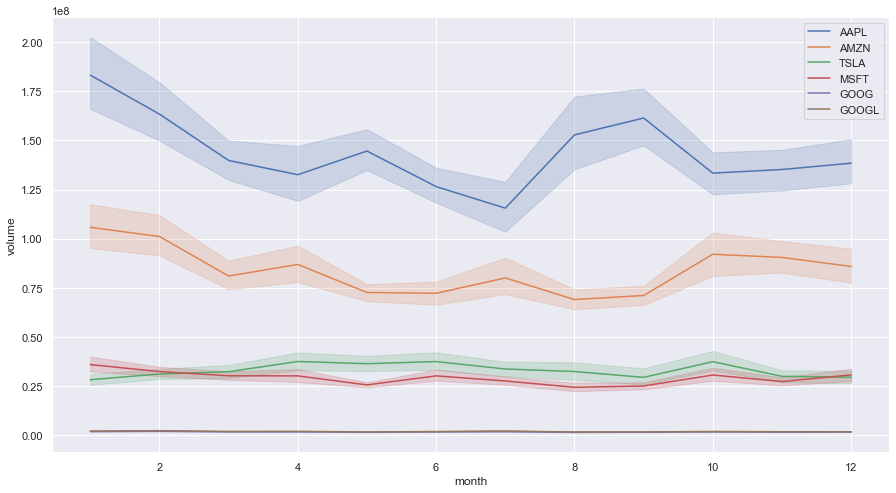

In [ ]:
for ticker in list_of_mentioned_tickers:
  # df_qoutes = df_qoutes[df_qoutes['ticker_symbol']==ticker]
  sns.set(rc = {'figure.figsize':(15,8)})
  sns.lineplot(data = df_qoutes[df_qoutes['ticker_symbol']==ticker], x="month", y="volume", label = ticker)
# # df_qoutes_AMZN

### **2.1.2 Daily volume per Ticker**

In [ ]:
fig_daily_volume = px.bar(df_qoutes, x="date", y='volume',color='ticker_symbol',title='Ticker_Daily_Volume')
fig_daily_volume.show()

## **2.2 Distribution of tweets by `date`,`tickers`,`engagement`**

### **2.2.1 Monthly tweets distribution throughout the period over Tickers**

<AxesSubplot:xlabel='date', ylabel='Count'>

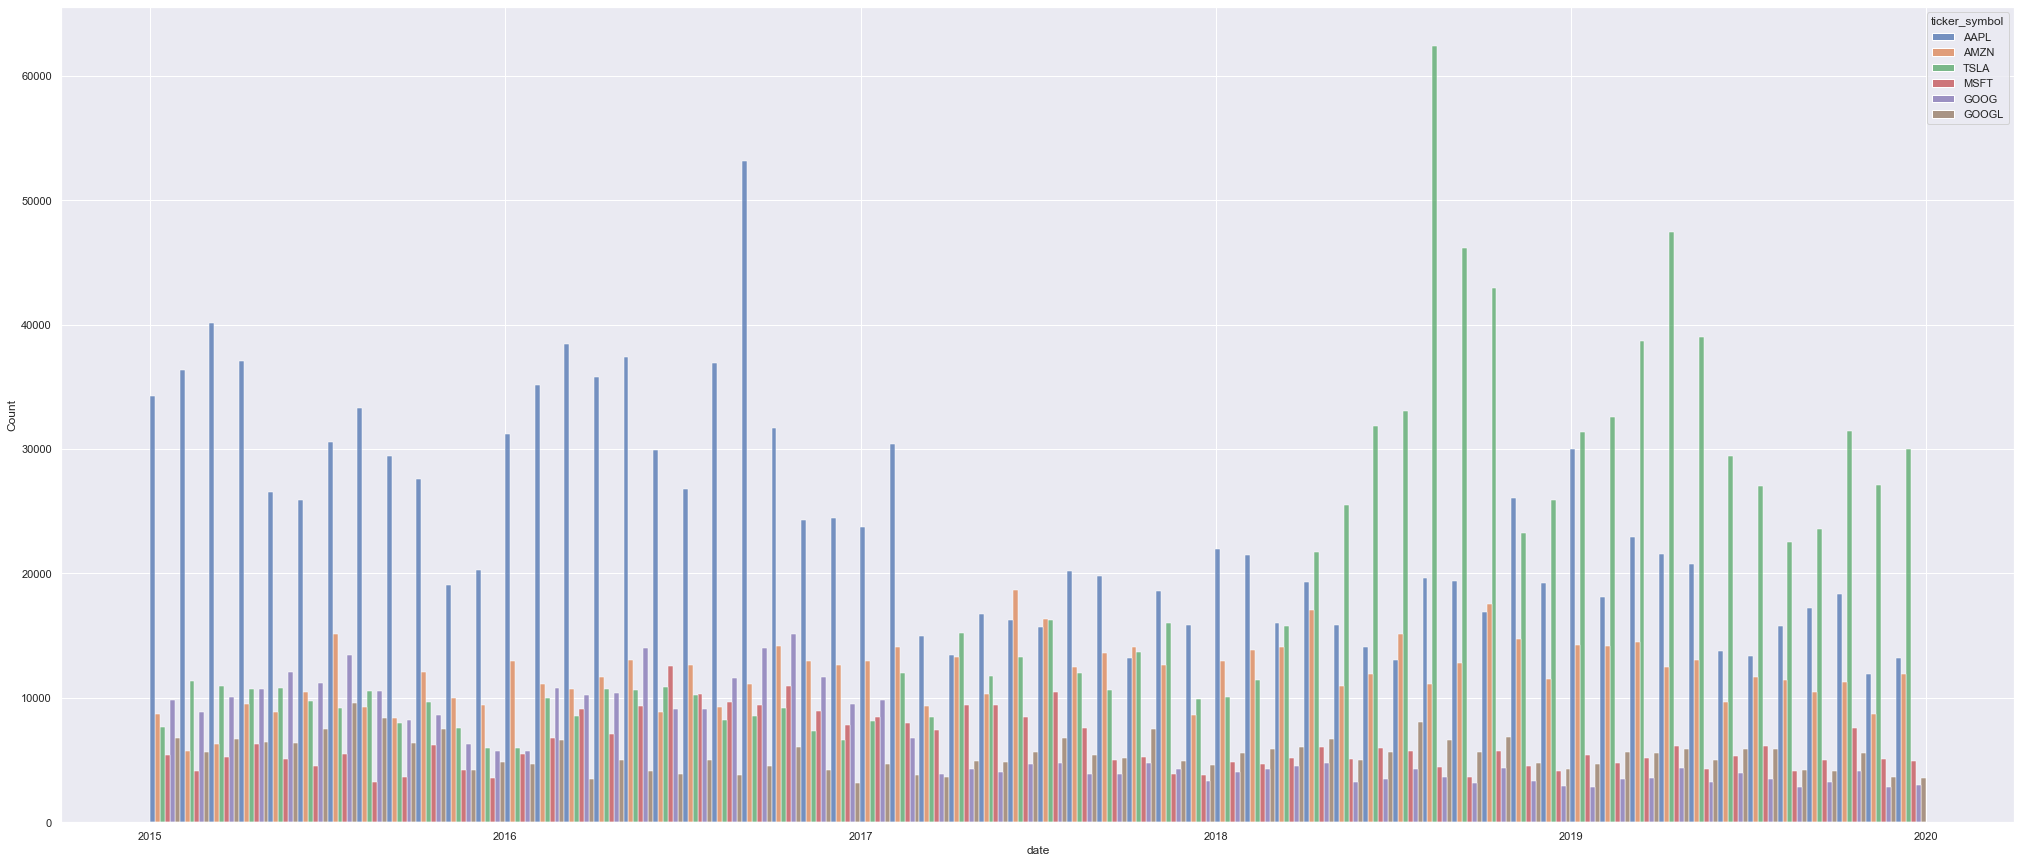

In [ ]:
plt.subplots(figsize=(35, 15))
sns.histplot(data=merged_df, x="date", hue="ticker_symbol", multiple="dodge", bins = 5*12)
#, cumulative=True, common_norm=False ,stat="density") 

### **2.2.2 Counting of tweets by Day per Ticker**

In [ ]:
fig_monthly_volume = px.bar(df_agg_tweet, x="ticker_symbol", y='tweet_id',color='day_name_x',title='Counting of tweets by WeekDay per Ticker')
fig_monthly_volume.show()

d = merged_df['ticker_symbol'].value_counts(ascending=True)
print("Total tweets throughout the whole period per ticker")
d

Total tweets throughout the whole period per ticker


GOOGL     327569
MSFT      375711
GOOG      392569
AMZN      718715
TSLA     1096868
AAPL     1425013
Name: ticker_symbol, dtype: int64

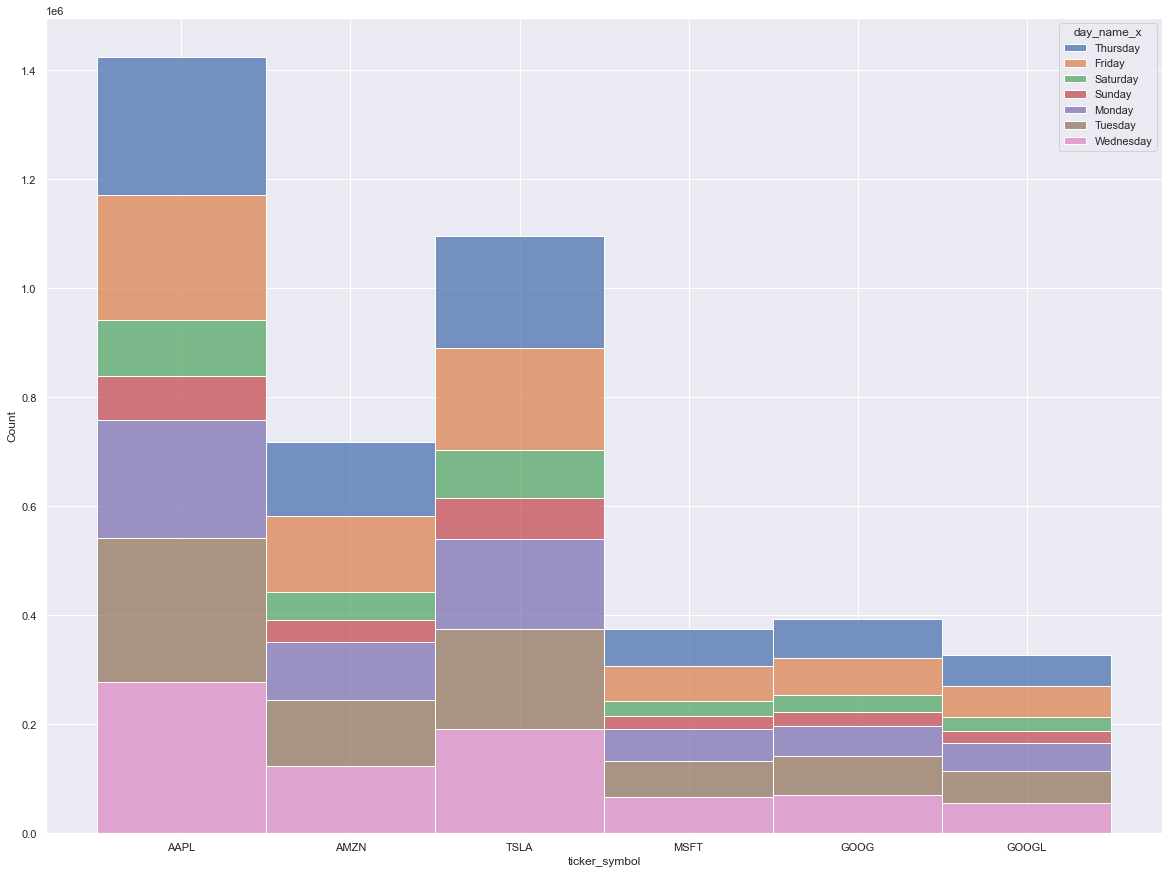

In [ ]:
plt.subplots(figsize=(20, 15))
tweets_per_day = sns.histplot(data=merged_df, x="ticker_symbol", hue="day_name_x", multiple="stack" , bins = 6)

### **2.2.3 Daily engagement per day**


In [ ]:
fig_monthly_volume = px.bar(df_agg_tweet, x="ticker_symbol", y='engagement',
                            color='day_name_x', barmode="group",
                            title='Daily engagement per day')
fig_monthly_volume.show()

### **2.2.4 Daily engagement per ticker**

In [ ]:
fig_monthly_volume = px.bar(df_agg_tweet, x="day_name_x", y='engagement',color='ticker_symbol',title='Daily engagement per Ticker')
fig_monthly_volume.show()

## **2.3 Tweets vs. Market-time-phase**

In [ ]:
df_agg_phase = merged_df.groupby(['day_name_x','ticker_symbol','phase'])\
                                                    .agg({
                                                        'tweet_id'          : "count",
                                                        # 'phase'             : "max",
                                                        # 'phase'             : "count", 
                                                        # 'comment_num'     : "sum",
                                                        # 'retweet_num'     : "sum",
                                                        # 'like_num'        : "sum",
                                                        # 'close'           : "max",
                                                        'month_x'           : "max",
                                                        # 'day_name_x'        : "count",
                                                        # 'volume'          : "max",
                                                        'engagement'        : "sum"}).reset_index()
                                                        

func_quick_analysis(df_agg_phase)
df_agg_phase

 >>> Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   day_name_x     132 non-null    object
 1   ticker_symbol  132 non-null    object
 2   phase          132 non-null    object
 3   tweet_id       132 non-null    int64 
 4   month_x        132 non-null    int64 
 5   engagement     132 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 6.3+ KB
None

-------------****----------------

 >>> Rows and Columns:
(132, 6)

-------------****----------------

 >>> Null Values:
day_name_x       0.0
ticker_symbol    0.0
phase            0.0
tweet_id         0.0
month_x          0.0
engagement       0.0
dtype: float64

-------------****----------------

 >>> Unique values:
day_name_x         7
ticker_symbol      6
phase              5
tweet_id         132
month_x            1
engagement       132
dtype: int64

-------------****-----

,day_name_x,ticker_symbol,phase,tweet_id,month_x,engagement
0,Friday,AAPL,After-market,71546,12,108973
1,Friday,AAPL,Market,39336,12,51958
2,Friday,AAPL,Pre-Market,24992,12,34347
3,Friday,AAPL,Trading-days-out-of-market-time,93655,12,161023
4,Friday,AMZN,After-market,48804,12,106457
...,...,...,...,...,...,...
127,Wednesday,MSFT,Trading-days-out-of-market-time,26966,12,45558
128,Wednesday,TSLA,After-market,59017,12,350638
129,Wednesday,TSLA,Market,28387,12,183213
130,Wednesday,TSLA,Pre-Market,20486,12,146034


In [ ]:
fig_tweets_per_phase = px.bar(df_agg_phase, x="phase", y='tweet_id',
                              color='ticker_symbol',barmode="group", 
                              facet_col="day_name_x" ,
                              # facet_row="day_name_x",
                              width=2000, height=1000,
                              title='Tweets per phase of market-time per Ticker')
fig_tweets_per_phase.show()

In [ ]:
fig_tweets_per_phase = px.bar(df_agg_phase, x='ticker_symbol', y='tweet_id',
                              color='phase',barmode="group", 
                              facet_col="day_name_x" ,
                              # facet_row="day_name_x",
                              width=1500, height=800,
                              title='Tweets per phase of market-time per Ticker')
fig_tweets_per_phase.show()

## **2.4 Tickers vs. Sentiment**

In [ ]:
func_quick_analysis(merged_df)

 >>> Data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 44 columns):
 #   Column            Dtype         
---  ------            -----         
 0   tweet_id          int64         
 1   writer            object        
 2   post_date         datetime64[ns]
 3   body              object        
 4   comment_num       int64         
 5   retweet_num       int64         
 6   like_num          int64         
 7   ticker_symbol     object        
 8   timeStamp_x       datetime64[ns]
 9   date              datetime64[ns]
 10  year_x            int64         
 11  quarter_x         int64         
 12  month_x           int64         
 13  week_x            int64         
 14  day_x             int64         
 15  hour_x            int64         
 16  minute_x          int64         
 17  seconds_x         int64         
 18  day_name_x        object        
 19  clean_text        object        
 20  sentiment_score   float64     

In [ ]:
df_agg_sentiment = merged_df.groupby(['ticker_symbol','phase','vander_sentiment'])\
                                                    .agg({
                                                        'tweet_id'          : "count",
                                                        # 'phase'           : "max",
                                                        # 'phase'           : "count", 
                                                        # 'comment_num'     : "sum",
                                                        # 'retweet_num'     : "sum",
                                                        # 'like_num'        : "sum",
                                                        # 'close'           : "max",
                                                        'month_x'           : "max",
                                                        'day_name_x'        : "max",
                                                        # 'volume'          : "max",
                                                        'engagement'        : "sum"}).reset_index()
                                                        

func_quick_analysis(df_agg_sentiment)
df_agg_sentiment

 >>> Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ticker_symbol     90 non-null     object
 1   phase             90 non-null     object
 2   vander_sentiment  90 non-null     object
 3   tweet_id          90 non-null     int64 
 4   month_x           90 non-null     int64 
 5   day_name_x        90 non-null     object
 6   engagement        90 non-null     int64 
dtypes: int64(3), object(4)
memory usage: 5.0+ KB
None

-------------****----------------

 >>> Rows and Columns:
(90, 7)

-------------****----------------

 >>> Null Values:
ticker_symbol       0.0
phase               0.0
vander_sentiment    0.0
tweet_id            0.0
month_x             0.0
day_name_x          0.0
engagement          0.0
dtype: float64

-------------****----------------

 >>> Unique values:
ticker_symbol        6
phase                5
vander_

,ticker_symbol,phase,vander_sentiment,tweet_id,month_x,day_name_x,engagement
0,AAPL,After-market,Negative,69937,12,Wednesday,120173
1,AAPL,After-market,Neutral,173825,12,Wednesday,236484
2,AAPL,After-market,Positive,146764,12,Wednesday,266949
3,AAPL,Market,Negative,35655,12,Wednesday,57411
4,AAPL,Market,Neutral,104755,12,Wednesday,119797
...,...,...,...,...,...,...,...
85,TSLA,Trading-days-out-of-market-time,Neutral,130049,12,Wednesday,708048
86,TSLA,Trading-days-out-of-market-time,Positive,160392,12,Wednesday,1208991
87,TSLA,Weekend-out-of-market-time,Negative,40181,12,Sunday,407469
88,TSLA,Weekend-out-of-market-time,Neutral,50713,12,Sunday,339513


In [ ]:
fig_tweet_sentiments = px.bar(df_agg_sentiment, x="vander_sentiment", y='tweet_id', 
                              color='ticker_symbol', barmode="group",
                              title='Sentiment distribution by ticker')
fig_tweet_sentiments.show()



# plt.subplots(figsize=(35, 15))
# sns.histplot(data=merged_df, x="date", hue="ticker_symbol", multiple="dodge", bins = 5*12)
# #, cumulative=True, common_norm=False ,stat="density") 

In [ ]:
fig_tweet_sentiments = px.bar(df_agg_sentiment, x="ticker_symbol", y='tweet_id', 
                              color='vander_sentiment', barmode="group",
                              title='Sentiment distribution by ticker')
fig_tweet_sentiments.show()


In [ ]:
fig_tweet_sentiments = px.bar(df_agg_sentiment, x='ticker_symbol', y='tweet_id',
                              color='phase',barmode="group", 
                              facet_col="day_name_x" ,
                              # facet_row="day_name_x",
                              width=1500, height=800,
                              title='Tweets per phase of market-time per Ticker')
fig_tweet_sentiments.show()

## **2.5 Distirbution of Tweets by week and day**

In [ ]:
def func_calculate_tweet_counts_for_date(df, ticker_symbol):
  tweet_count_for_date = df[(df["ticker_symbol"] == ticker_symbol)].groupby('date')['tweet_id'].count()
  tweet_count_for_date = pd.DataFrame(tweet_count_for_date.reset_index())
  tweet_count_for_date.columns = ['date', 'tweet_count']
  return tweet_count_for_date

  
df_counts = func_calculate_tweet_counts_for_date(merged_df, 'AAPL')

In [ ]:
def func_calculate_tweet_weekly_average(df_counts, df, ticker_symbol):
  for index in df_counts.index:
    start_interval = df_counts.loc[index, 'date'] - timedelta(days=3)
    end_interval = df_counts.loc[index, 'date'] + timedelta(days=3)
    df_counts.loc[index, f"{ticker_symbol}_tweet_weekly_average"] = len(df[(df["ticker_symbol"] == ticker_symbol) & (df["date"] > start_interval) & (df["date"] < end_interval)])/7
  df_counts[f"{ticker_symbol}_tweet_weekly_average"] = df_counts[f"{ticker_symbol}_tweet_weekly_average"].astype(int)
  return df_counts

  
df_weekly_average = func_calculate_tweet_weekly_average(df_counts, merged_df, 'AAPL')

In [ ]:
df_weekly_average

,date,tweet_count,AAPL_tweet_weekly_average
0,2015-01-01,250,214
1,2015-01-02,867,269
2,2015-01-03,382,427
3,2015-01-04,390,562
4,2015-01-05,1100,595
...,...,...,...
1822,2019-12-28,229,310
1823,2019-12-29,195,317
1824,2019-12-30,706,264
1825,2019-12-31,691,231


In [ ]:
fig = make_subplots(rows=3, cols=1)
fig1 = px.bar(df_counts, x="date", y="tweet_count")
fig1.update_traces(marker_color='blue')
fig2 = px.bar(df_counts, x="date", y="AAPL_tweet_weekly_average")
fig1.update_traces(marker_color='purple')
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig2['data'][0], row=1, col=1)
fig.show()

In [ ]:
df_weekly_average.to_csv(r'G:\.shortcut-targets-by-id\1UCjJN85yZsLXEysVYnWJ7yGswKobq0r7\Data\DS_Naya\Stock_Market_Exploration\Datasets\df_weekly_average.csv',index=False)

## **2.6 Plotting sentiment score vs ticker quotes**

In [ ]:
df_ticker_sentiment_phase = pd.read_csv(r'G:\.shortcut-targets-by-id\1UCjJN85yZsLXEysVYnWJ7yGswKobq0r7\Data\DS_Naya\Stock_Market_Exploration\Datasets\df_ticker_sentiment_phase.csv',
                                        encoding='utf-8' ,
                                        parse_dates=['post_date','date','timeStamp']
                                        )

func_quick_analysis(df_ticker_sentiment_phase)

 >>> Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 25 columns):
 #   Column            Dtype         
---  ------            -----         
 0   tweet_id          int64         
 1   writer            object        
 2   post_date         datetime64[ns]
 3   body              object        
 4   comment_num       int64         
 5   retweet_num       int64         
 6   like_num          int64         
 7   ticker_symbol     object        
 8   timeStamp         datetime64[ns]
 9   date              datetime64[ns]
 10  year              int64         
 11  quarter           int64         
 12  month             int64         
 13  week              int64         
 14  day               int64         
 15  hour              int64         
 16  minute            int64         
 17  seconds           int64         
 18  day_name          object        
 19  clean_text        object        
 20  sentiment_score   float64     

In [ ]:
list_of_mentioned_tickers = func_get_list_of_mentioned_tickers(df_ticker_sentiment_phase, "ticker_symbol")

print("The whole mentiones tickers in \"df_ticker_sentiment_phase\"")
for (i, tkr) in enumerate(list_of_mentioned_tickers):
  print(i, tkr)
print("---------------------------------------------------\n")


# Getting the whole needed period time
starting_date = min(df_ticker_sentiment_phase['post_date']) - timedelta(days=1)
print(starting_date)

Last_date = max(df_ticker_sentiment_phase['post_date'])
print(Last_date)

# Using List Comprehension
quotes_data = [get_data(ticker , start_date=starting_date, end_date=Last_date, index_as_date = False, interval="1d") for ticker in list_of_mentioned_tickers]
quotes_data

rows_counter = len(quotes_data[0])
ticker_counter = len(quotes_data)
columns_counter = len(quotes_data[0].columns)


# Reshape "quotes_data"
quotes_data = np.reshape(quotes_data, (ticker_counter*rows_counter, columns_counter) ) ### total array of 8*6*1259 == 60,432
# quotes_data = np.reshape(quotes_data,(6*1259,8)) 
quotes_data


df_qoutes = pd.DataFrame(quotes_data, columns = ['date', 'open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker_symbol'])

df_qoutes['Date'] = pd.to_datetime(df_qoutes['date'], errors='ignore')
func_convert_dateTime_df_to_elementTime(df_qoutes, "Date")
df_qoutes['date']  = df_qoutes['Date'] 
df_qoutes.info()
df_qoutes

The whole mentiones tickers in "df_ticker_sentiment_phase"
0 AAPL
1 AMZN
2 TSLA
3 MSFT
4 GOOG
5 GOOGL
---------------------------------------------------

2014-12-31 02:00:57
2020-01-01 01:55:53
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7554 entries, 0 to 7553
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           7554 non-null   datetime64[ns]
 1   open           7554 non-null   object        
 2   high           7554 non-null   object        
 3   low            7554 non-null   object        
 4   close          7554 non-null   object        
 5   adjclose       7554 non-null   object        
 6   volume         7554 non-null   object        
 7   ticker_symbol  7554 non-null   object        
 8   Date           7554 non-null   datetime64[ns]
 9   timeStamp      7554 non-null   datetime64[ns]
 10  year           7554 non-null   int64         
 11  quarter        7554 non-null  

C:\Users\biton\AppData\Local\Temp\ipykernel_11544\3820899794.py:28: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



,date,open,high,low,close,adjclose,volume,ticker_symbol,Date,timeStamp,year,quarter,year_quarter,month,week,day,hour,minute,seconds,day_name
0,2014-12-31,28.205,28.282499,27.5525,27.594999,24.915258,165613600,AAPL,2014-12-31,2014-12-31,2014,4,2014Q4,12,1,31,0,0,0,Wednesday
1,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.678247,212818400,AAPL,2015-01-02,2015-01-02,2015,1,2015Q1,1,1,2,0,0,0,Friday
2,2015-01-05,27.0725,27.1625,26.352501,26.5625,23.983019,257142000,AAPL,2015-01-05,2015-01-05,2015,1,2015Q1,1,2,5,0,0,0,Monday
3,2015-01-06,26.635,26.8575,26.157499,26.565001,23.985283,263188400,AAPL,2015-01-06,2015-01-06,2015,1,2015Q1,1,2,6,0,0,0,Tuesday
4,2015-01-07,26.799999,27.049999,26.674999,26.9375,24.321606,160423600,AAPL,2015-01-07,2015-01-07,2015,1,2015Q1,1,2,7,0,0,0,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7549,2019-12-24,1350.209961,1352.01001,1344.170044,1344.430054,1344.430054,673400,GOOGL,2019-12-24,2019-12-24,2019,4,2019Q4,12,52,24,0,0,0,Tuesday
7550,2019-12-26,1346.550049,1363.199951,1345.51001,1362.469971,1362.469971,1183100,GOOGL,2019-12-26,2019-12-26,2019,4,2019Q4,12,52,26,0,0,0,Thursday
7551,2019-12-27,1364.0,1367.050049,1353.0,1354.640015,1354.640015,1160600,GOOGL,2019-12-27,2019-12-27,2019,4,2019Q4,12,52,27,0,0,0,Friday
7552,2019-12-30,1356.810059,1357.0,1337.839966,1339.709961,1339.709961,999700,GOOGL,2019-12-30,2019-12-30,2019,4,2019Q4,12,1,30,0,0,0,Monday


In [ ]:
df_ticker_sentiment_phase_merged_quotes = df_ticker_sentiment_phase.merge(df_qoutes, on=['date','ticker_symbol'], how='left')
func_quick_analysis(df_ticker_sentiment_phase_merged_quotes)

 >>> Data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 43 columns):
 #   Column            Dtype         
---  ------            -----         
 0   tweet_id          int64         
 1   writer            object        
 2   post_date         datetime64[ns]
 3   body              object        
 4   comment_num       int64         
 5   retweet_num       int64         
 6   like_num          int64         
 7   ticker_symbol     object        
 8   timeStamp_x       datetime64[ns]
 9   date              datetime64[ns]
 10  year_x            int64         
 11  quarter_x         int64         
 12  month_x           int64         
 13  week_x            int64         
 14  day_x             int64         
 15  hour_x            int64         
 16  minute_x          int64         
 17  seconds_x         int64         
 18  day_name_x        object        
 19  clean_text        object        
 20  sentiment_score   float64     

In [ ]:
df_ticker_sentiment_phase_merged_quotes = df_ticker_sentiment_phase_merged_quotes.dropna(axis=0, subset=['close'])
func_quick_analysis(df_ticker_sentiment_phase_merged_quotes)

 >>> Data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3683407 entries, 615 to 4336329
Data columns (total 43 columns):
 #   Column            Dtype         
---  ------            -----         
 0   tweet_id          int64         
 1   writer            object        
 2   post_date         datetime64[ns]
 3   body              object        
 4   comment_num       int64         
 5   retweet_num       int64         
 6   like_num          int64         
 7   ticker_symbol     object        
 8   timeStamp_x       datetime64[ns]
 9   date              datetime64[ns]
 10  year_x            int64         
 11  quarter_x         int64         
 12  month_x           int64         
 13  week_x            int64         
 14  day_x             int64         
 15  hour_x            int64         
 16  minute_x          int64         
 17  seconds_x         int64         
 18  day_name_x        object        
 19  clean_text        object        
 20  sentiment_score   float64   

In [ ]:
df_agg_ticker_sentiment_phase = df_ticker_sentiment_phase_merged_quotes.groupby(['date','ticker_symbol'])\
                                                    .agg({
                                                        'tweet_id'          : "count", 
                                                        # 'comment_num'       : "sum",
                                                        # 'retweet_num'       : "sum",
                                                        # 'like_num'          : "sum",
                                                        'close'             : "max",
                                                        # 'month_x'           : "max",
                                                        # 'day_name_x'        : "max",
                                                        # 'ticker_symbol'     : "max",
                                                        'volume'            : "max",
                                                        # 'engagement'      : "sum",
                                                        'vander_score'      : "sum",
                                                        'sentiment_score'   : "sum"
                                                        }).reset_index()
                                                        

func_quick_analysis(df_agg_ticker_sentiment_phase)
df_agg_ticker_sentiment_phase

In [ ]:
def func_sentiment_overtime(tweet_df, stock_df, title, score_column_name="sentiment_score"):
    print("\n\n")
    fig = plt.figure(figsize=(24,10))
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    
#   ax1.plot(tweet_df['day_date'], tweet_df[score_column_name], label='Tweets Sentiment')
    ax1.vlines(tweet_df['date'], 0, tweet_df[score_column_name]) 
    ax1.axhline(y=0, color='r', linestyle='-')

    
    ax2.plot(stock_df['date'], stock_df['close'], color='orange', label='Stock price')
    ax2.set_title("Effects of " + title + " tweets to stock price")
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    ax1.set_xlabel('Day date')
    ax1.set_ylabel('Sentiment Afinn score', color="blue")
    
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
#     center_y = max(stock_df['close_value']) - min(stock_df['close_value']) / 2
#     print(center_y)
    
    plt.show()

In [ ]:
ticker_symbols =  df_ticker_sentiment_phase["ticker_symbol"].unique()

In [ ]:
def func_draw_stock_price_with_sentiment(tweet_df, stock_df, start_day, end_day, score_name):
    for ticker_symbol in ticker_symbols:
        print(f"Ticker symbol: {ticker_symbol}")

        sub_company = df_ticker_sentiment_phase[df_ticker_sentiment_phase["ticker_symbol"] == ticker_symbol]["ticker_symbol"]
        # sub_company = company[company["ticker_symbol"] == ticker_symbol]["ticker_symbol"]
        # if len(sub_company) != 1:
        #     continue

        # company_name = sub_company.iloc[0]
        # print(company_name)

        print(f"Stock price of {ticker_symbol} company with ticker symbol is {ticker_symbol}")
        # print(f"Stock price of {company_name} company with ticker symbol is {ticker_symbol}")


        sub_tweet_df = tweet_df[tweet_df["ticker_symbol"] == ticker_symbol]
        sub_tweet_df = sub_tweet_df[(sub_tweet_df["date"]>=pd.to_datetime(start_day)) & (sub_tweet_df["date"]<=pd.to_datetime(end_day))]
    #     print(sub_tweet_df[:5])
        sub_stock_df = stock_df[stock_df["ticker_symbol"] == ticker_symbol]
        sub_stock_df = sub_stock_df[(sub_stock_df["date"]>=pd.to_datetime(start_day)) & (sub_stock_df["date"]<=pd.to_datetime(end_day))]

    #     print(sub_stock_df[:5])
        func_sentiment_overtime(sub_tweet_df, sub_stock_df, ticker_symbol, score_column_name=score_name)
        # sentiment_overtime(sub_tweet_df, sub_stock_df, company_name, score_column_name=score_name)

        plt.show()

Ticker symbol: AAPL
Stock price of AAPL company with ticker symbol is AAPL





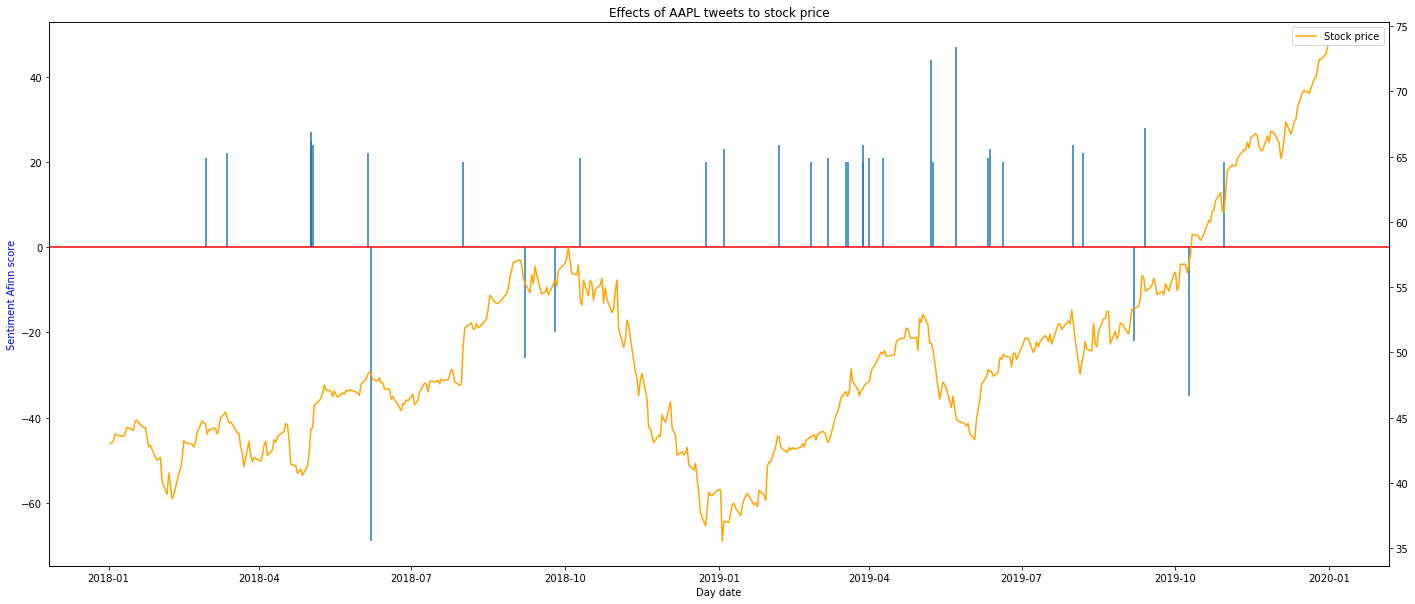

Ticker symbol: AMZN
Stock price of AMZN company with ticker symbol is AMZN





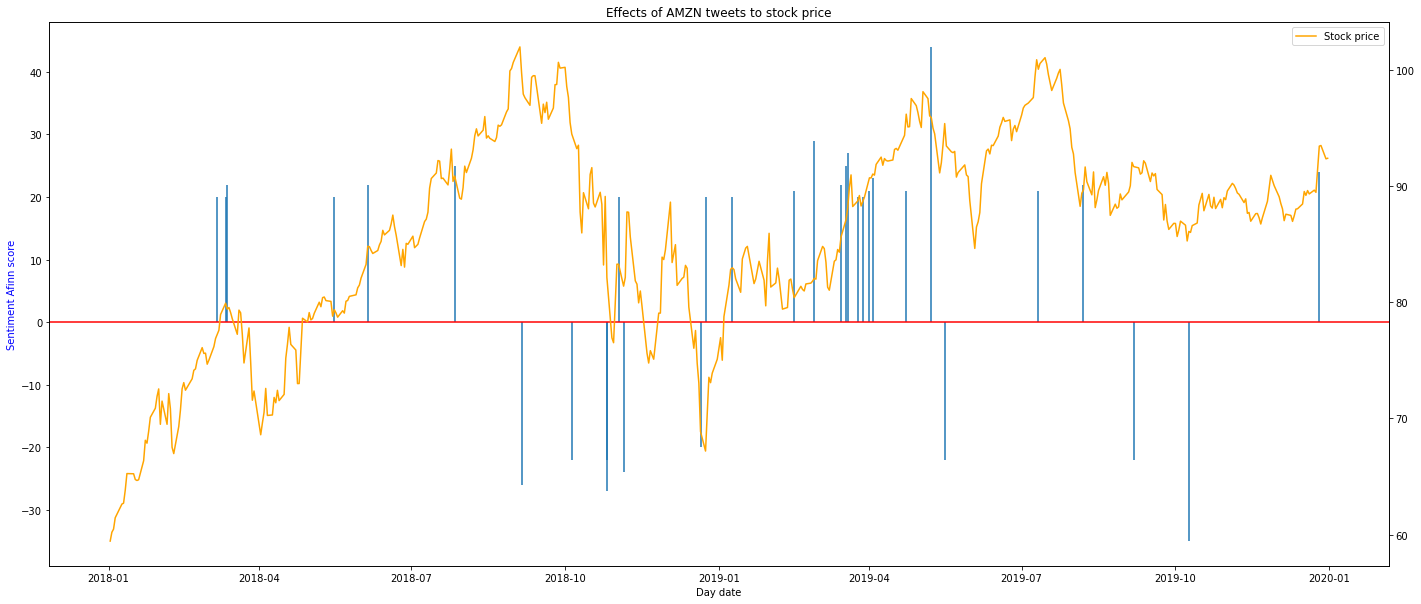

Ticker symbol: TSLA
Stock price of TSLA company with ticker symbol is TSLA





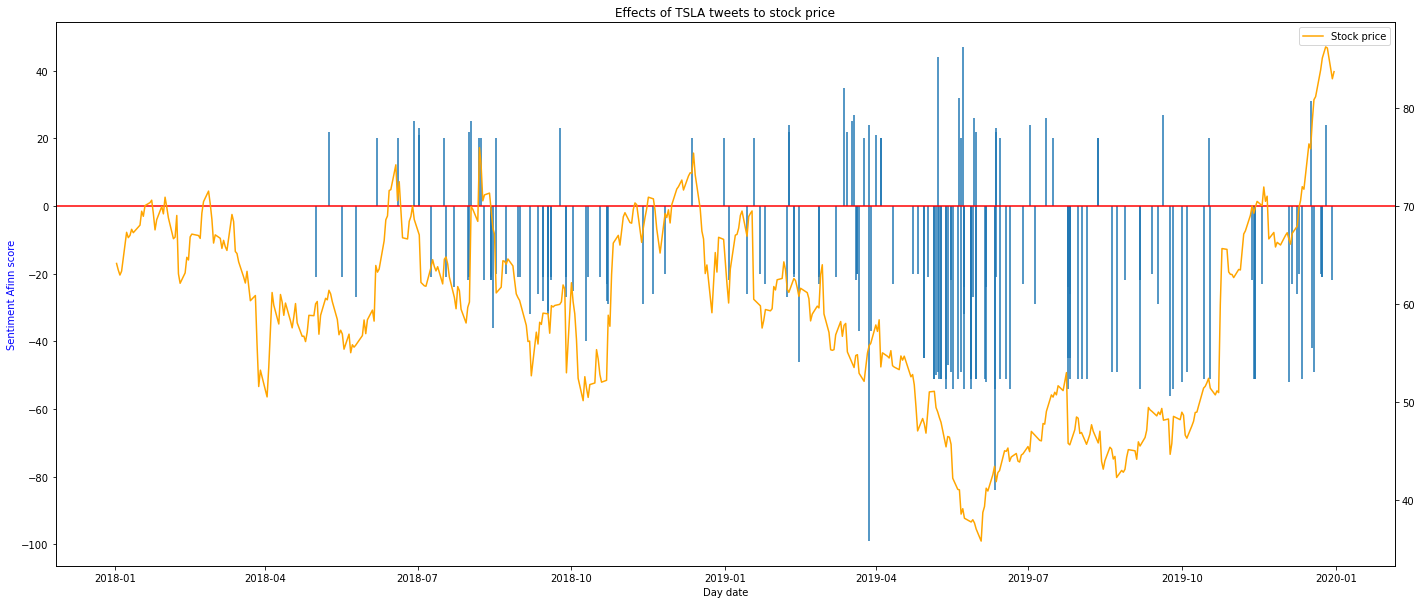

Ticker symbol: MSFT
Stock price of MSFT company with ticker symbol is MSFT





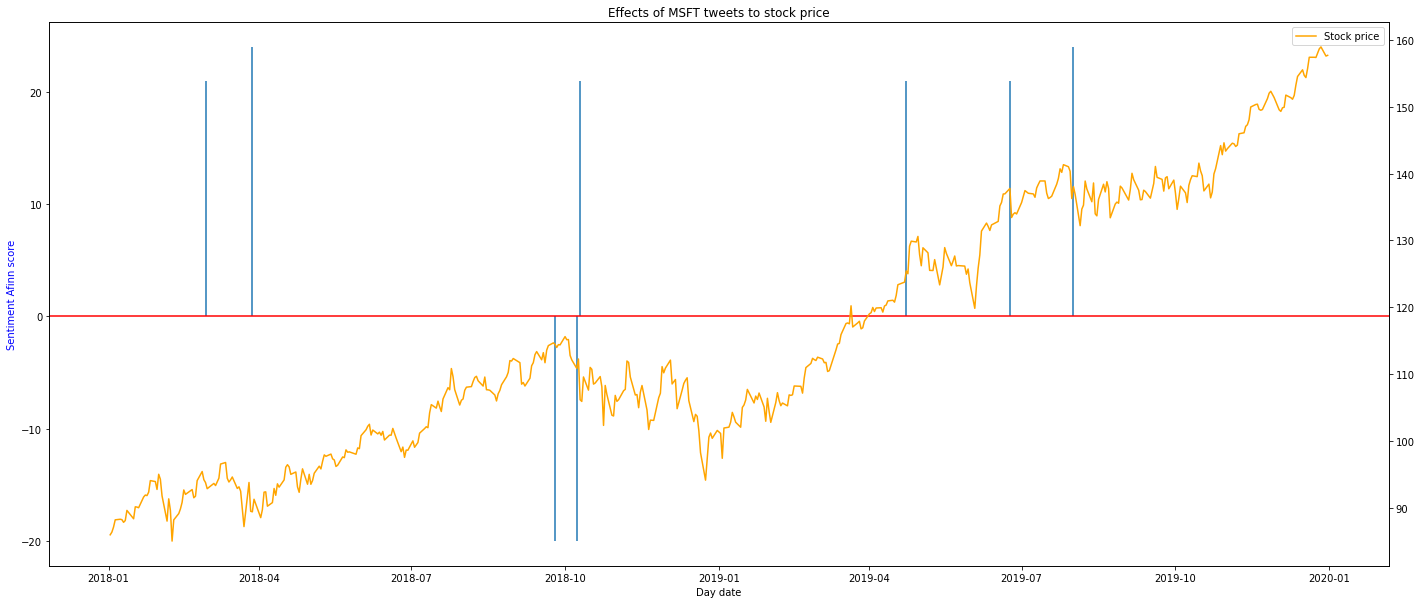

Ticker symbol: GOOG
Stock price of GOOG company with ticker symbol is GOOG





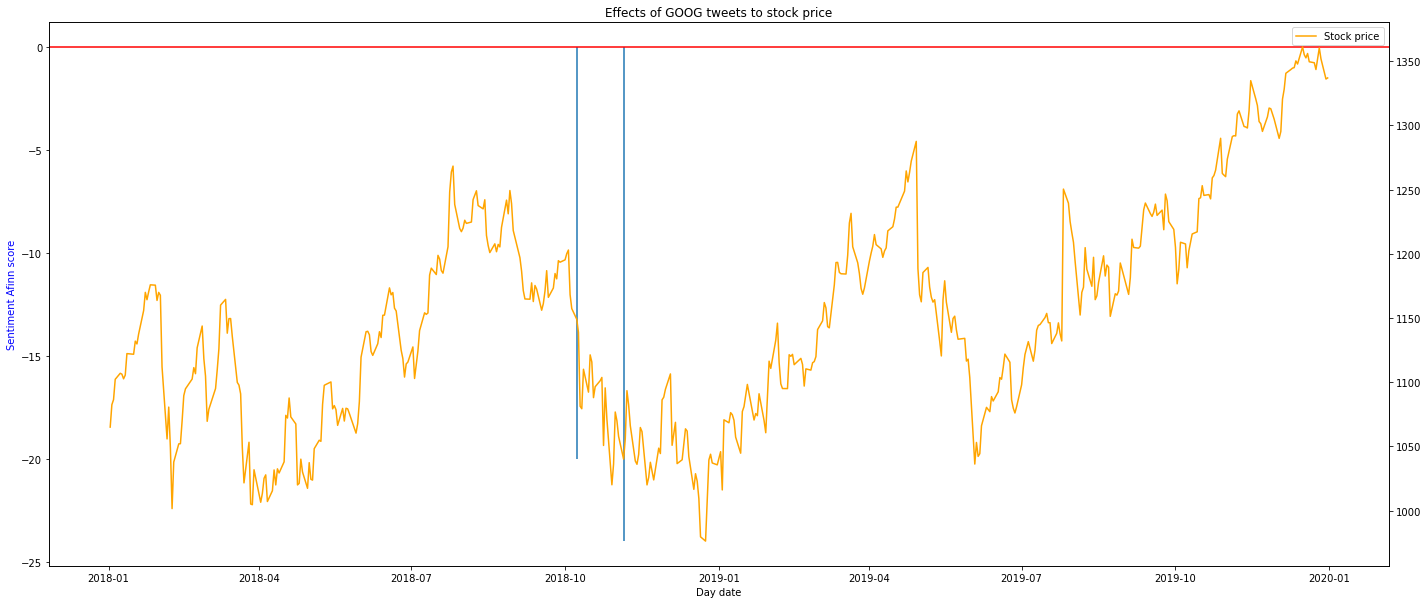

Ticker symbol: GOOGL
Stock price of GOOGL company with ticker symbol is GOOGL





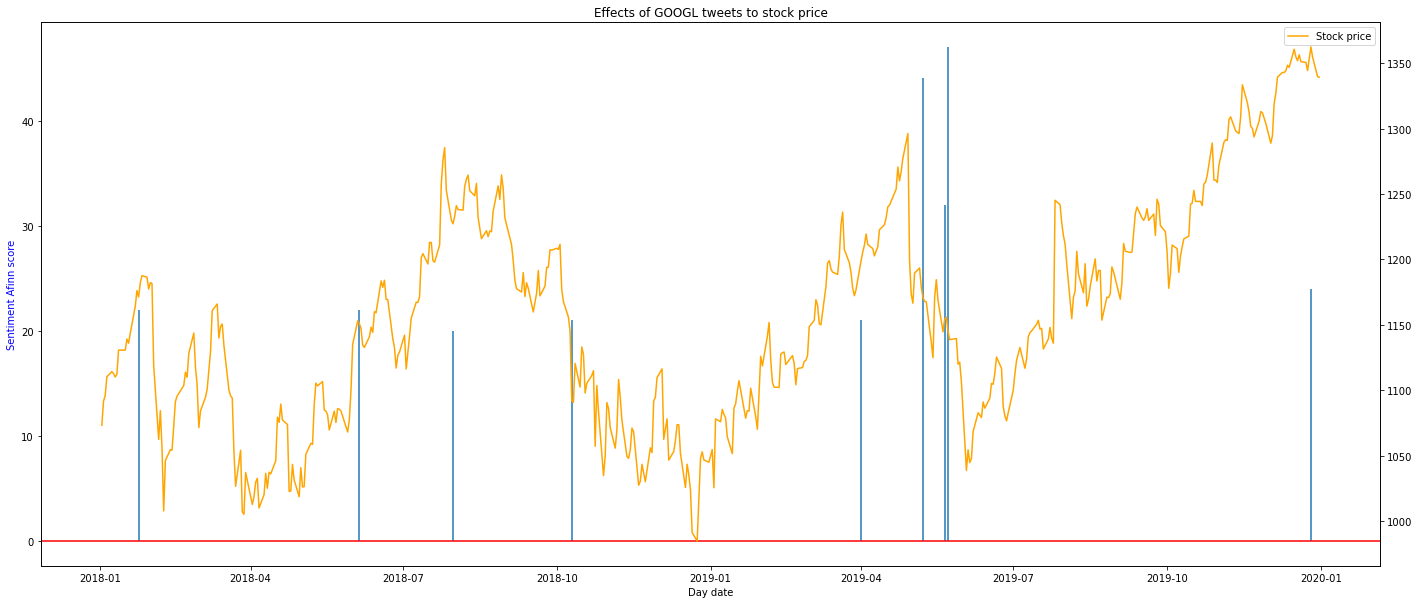

In [ ]:
# Param
score_threshold = 20
score_column = "sentiment_score"

tmp_tweet_df = df_ticker_sentiment_phase_merged_quotes[(df_ticker_sentiment_phase_merged_quotes[score_column]<=-score_threshold) | (df_ticker_sentiment_phase_merged_quotes[score_column]>=score_threshold)]

func_draw_stock_price_with_sentiment(tmp_tweet_df, 
                                     df_qoutes,
                                     start_day= dt(2018, 1, 1),
                                    #  start_day= min(df_qoutes['date']), 
                                     end_day= max(df_qoutes['date']), 
                                     score_name=score_column)

Ticker symbol: AAPL
Stock price of AAPL company with ticker symbol is AAPL





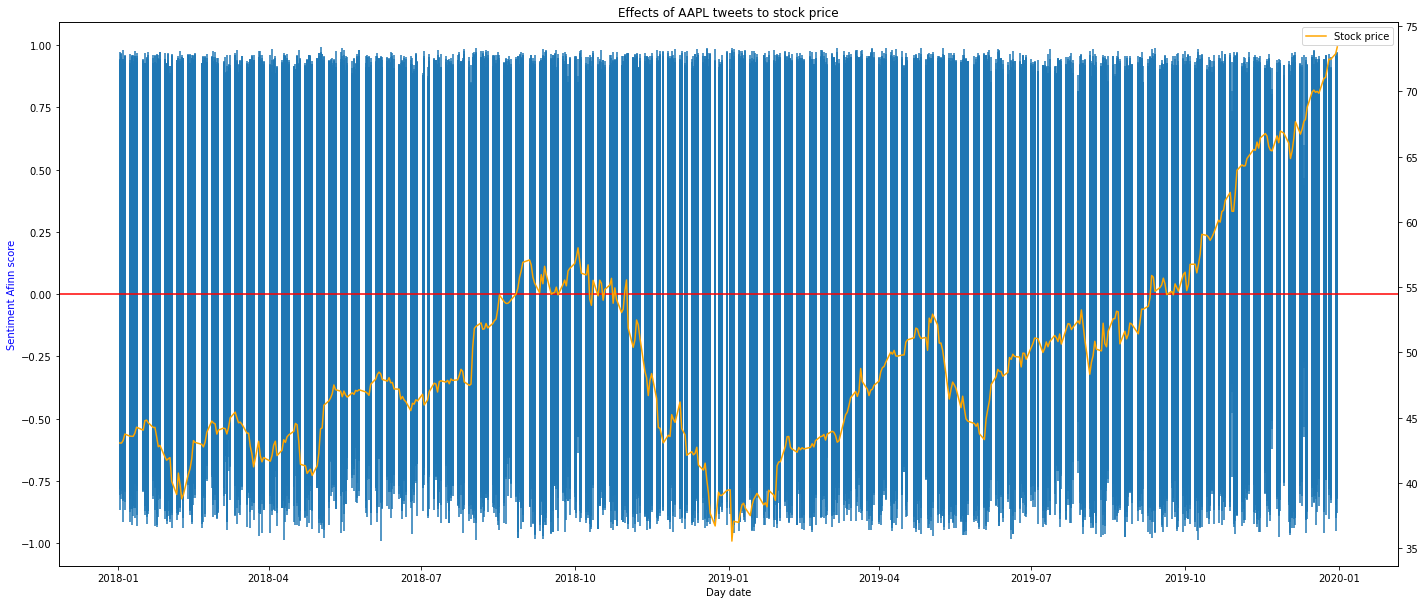

Ticker symbol: AMZN
Stock price of AMZN company with ticker symbol is AMZN





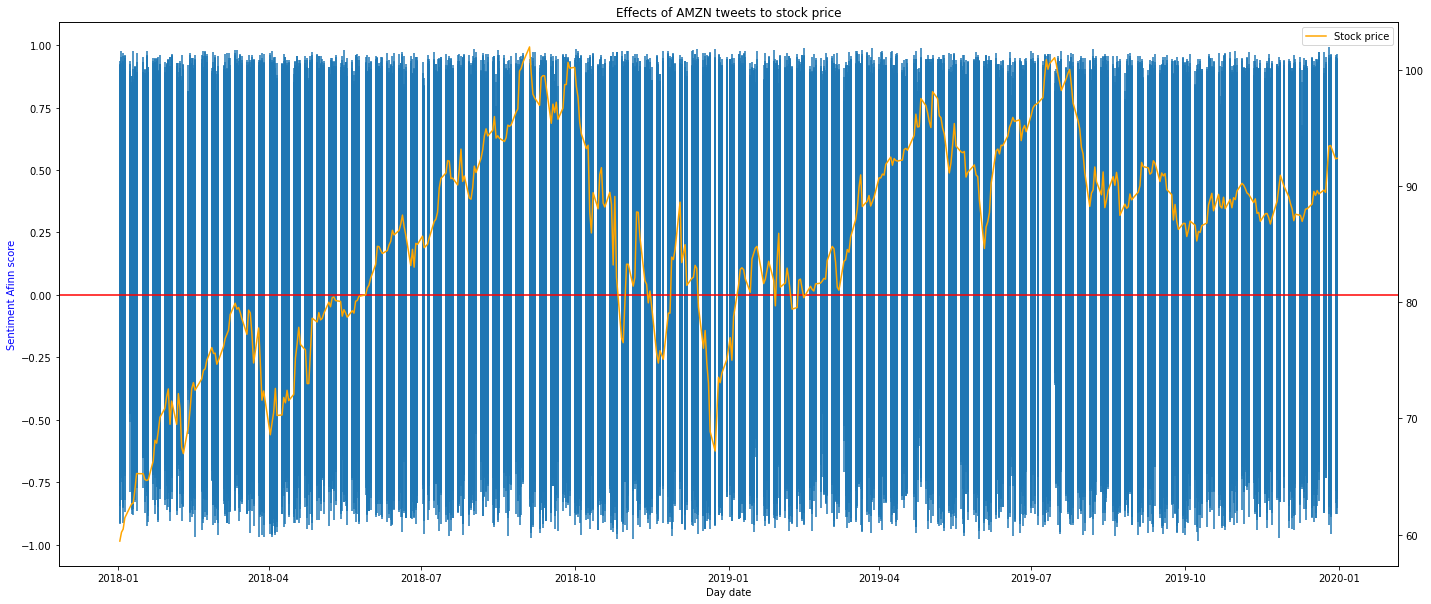

Ticker symbol: TSLA
Stock price of TSLA company with ticker symbol is TSLA





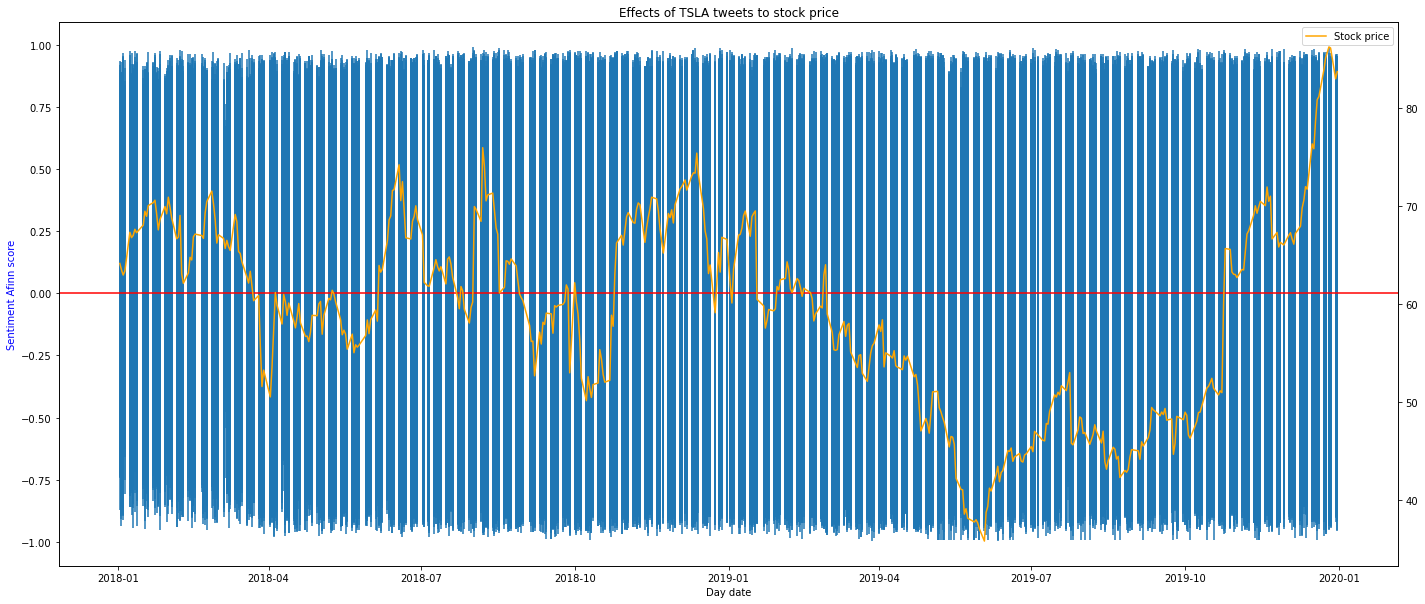

Ticker symbol: MSFT
Stock price of MSFT company with ticker symbol is MSFT





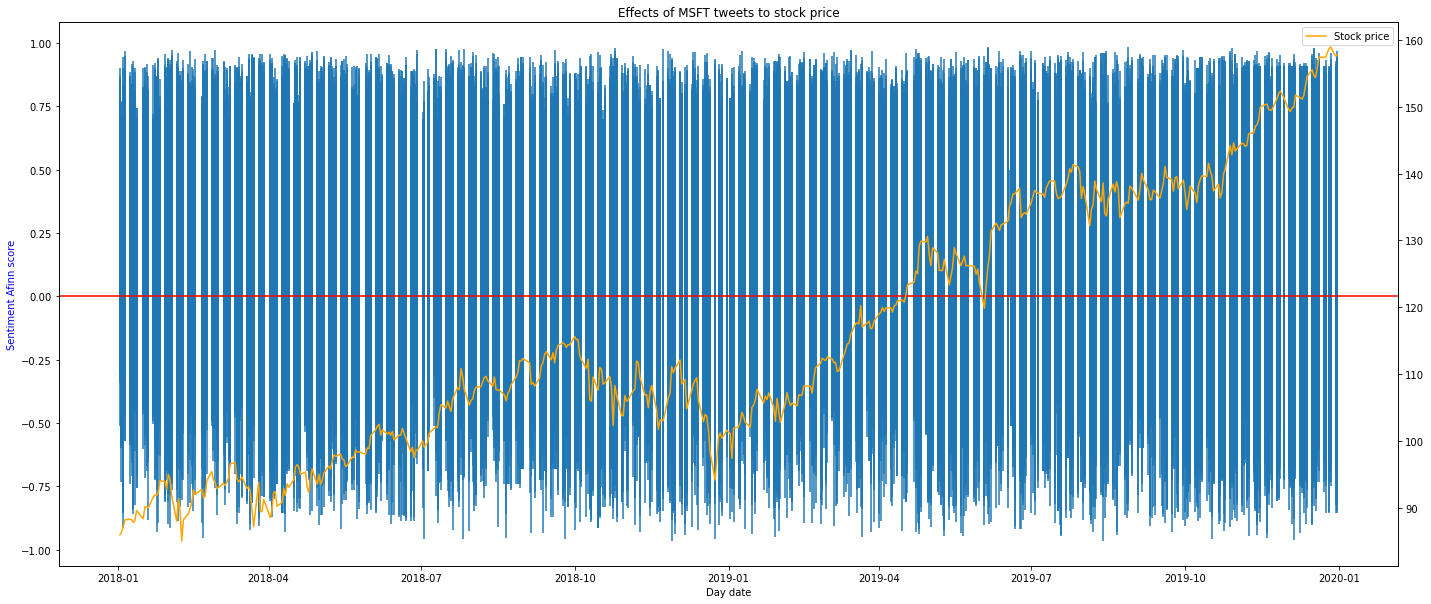

Ticker symbol: GOOG
Stock price of GOOG company with ticker symbol is GOOG





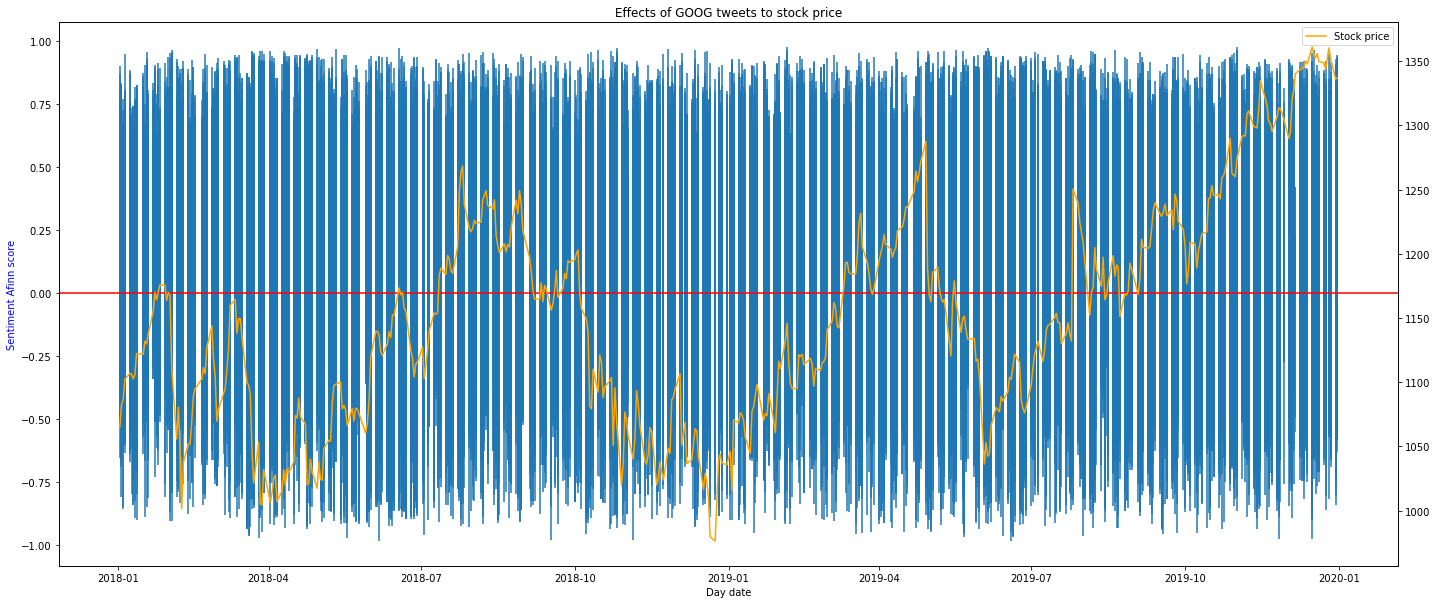

Ticker symbol: GOOGL
Stock price of GOOGL company with ticker symbol is GOOGL





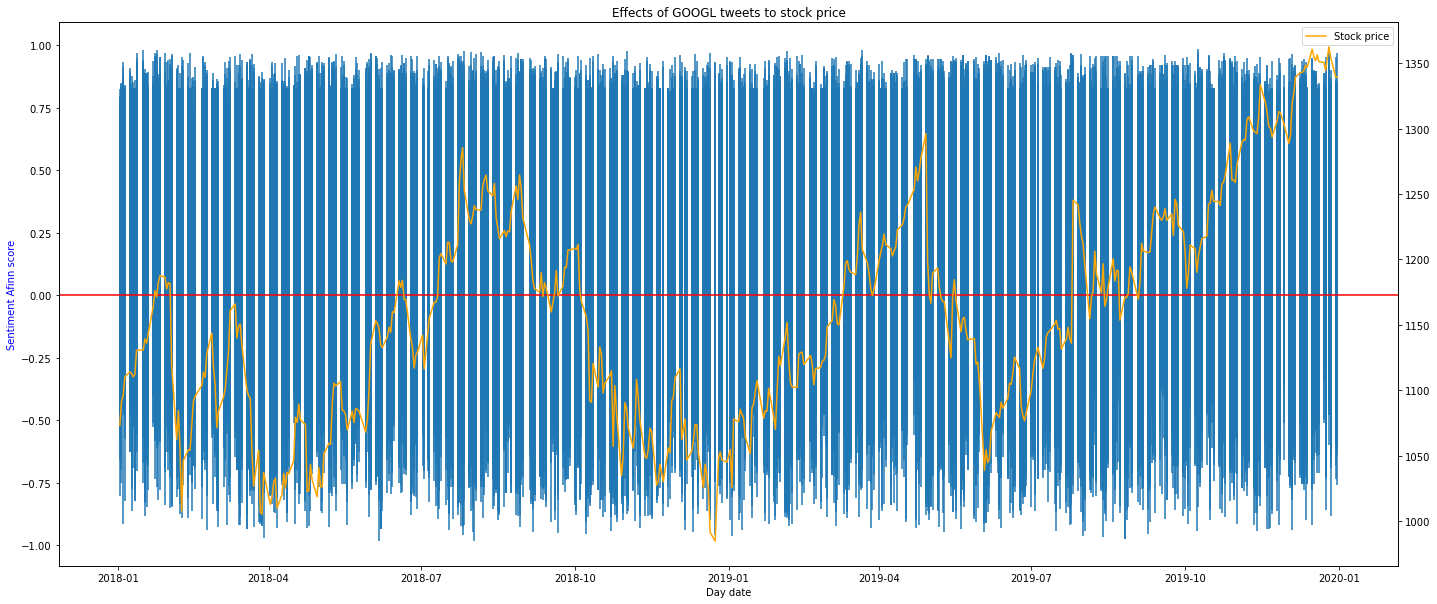

In [ ]:
# Param
score_threshold = 0
score_column = "vander_score"

tmp_tweet_df = df_ticker_sentiment_phase_merged_quotes[(df_ticker_sentiment_phase_merged_quotes[score_column]<=-score_threshold) | (df_ticker_sentiment_phase_merged_quotes[score_column]>=score_threshold)]

func_draw_stock_price_with_sentiment(tmp_tweet_df, 
                                     df_qoutes,
                                     start_day= dt(2018, 1, 1),
                                    #  start_day= min(df_qoutes['date']), 
                                     end_day= max(df_qoutes['date']), 
                                     score_name=score_column)

## **2.7 Correlation between Sentiments to Volume**

In [ ]:
df_ticker_sentiment_phase_merged_quotes.info()

In [ ]:
df_agg = df_ticker_sentiment_phase_merged_quotes.groupby(['date','ticker_symbol','vander_sentiment'])\
                                                    .agg({
                                                        # 'tweet_id'          : "count", 
                                                        # 'comment_num'       : "sum",
                                                        # 'retweet_num'       : "sum",
                                                        # 'like_num'          : "sum",
                                                        # 'close'             : "max",
                                                        # 'month_x'           : "max",
                                                        # 'day_name_x'        : "max",
                                                        # 'ticker_symbol'     : "max",
                                                        'volume'            : "max",
                                                        # 'engagement'      : "sum",
                                                        'vander_score'      : "sum",
                                                        'sentiment_score'   : "sum"
                                                        }).reset_index()
                                                        

func_quick_analysis(df_agg)
df_agg

 >>> Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22641 entries, 0 to 22640
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              22641 non-null  datetime64[ns]
 1   ticker_symbol     22641 non-null  object        
 2   vander_sentiment  22641 non-null  object        
 3   volume            22641 non-null  int64         
 4   vander_score      22641 non-null  float64       
 5   sentiment_score   22641 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.0+ MB
None

-------------****----------------

 >>> Rows and Columns:
(22641, 6)

-------------****----------------

 >>> Null Values:
date                0.0
ticker_symbol       0.0
vander_sentiment    0.0
volume              0.0
vander_score        0.0
sentiment_score     0.0
dtype: float64

-------------****----------------

 >>> Unique values:
date               

,date,ticker_symbol,vander_sentiment,volume,vander_score,sentiment_score
0,2015-01-02,AAPL,Negative,212818400,-61.9308,-238.0
1,2015-01-02,AAPL,Neutral,212818400,0.0000,-10.0
2,2015-01-02,AAPL,Positive,212818400,131.8513,598.0
3,2015-01-02,AMZN,Negative,55664000,-13.4258,-52.0
4,2015-01-02,AMZN,Neutral,55664000,0.0000,2.0
...,...,...,...,...,...,...
22636,2019-12-31,MSFT,Neutral,18369400,0.0000,8.0
22637,2019-12-31,MSFT,Positive,18369400,59.2629,413.0
22638,2019-12-31,TSLA,Negative,51428500,-121.0837,-676.0
22639,2019-12-31,TSLA,Neutral,51428500,0.0000,20.0


In [ ]:
for ticker in ticker_symbols:
  df_agg_x = df_agg[df_agg['ticker_symbol']==ticker]
  vander_corr = df_agg_x[['vander_score','volume']].corr(method="spearman")
  sent_corr = df_agg_x[['sentiment_score','volume']].corr(method="spearman")
  print("\n\n-----\n\n")
  print("Correlation for {}".format(ticker))
  print(vander_corr)
  print('\n')
  print(sent_corr)




-----


Correlation for AAPL
              vander_score    volume
vander_score      1.000000 -0.023216
volume           -0.023216  1.000000


                 sentiment_score    volume
sentiment_score         1.000000 -0.002726
volume                 -0.002726  1.000000


-----


Correlation for AMZN
              vander_score    volume
vander_score      1.000000 -0.004911
volume           -0.004911  1.000000


                 sentiment_score    volume
sentiment_score         1.000000  0.026192
volume                  0.026192  1.000000


-----


Correlation for TSLA
              vander_score    volume
vander_score      1.000000  0.003558
volume            0.003558  1.000000


                 sentiment_score    volume
sentiment_score         1.000000  0.017041
volume                  0.017041  1.000000


-----


Correlation for MSFT
              vander_score    volume
vander_score      1.000000 -0.009231
volume           -0.009231  1.000000


                 sentiment_score    v

****
****
****
****
****
****

# **# References!!!**
****

## **# 03-07-2022**
****

### **Import the last df**
`df_ticker_quotes_sentiment_phase`


In [ ]:
# df_tweet_tickers_quotes = pd.read_csv(r'Z:\GoogleDrive\MyDrive\Knowledge\Data\DS_Naya\Stock_Market_Exploration\Datasets\df_tweet_tickers_quotes.zip', encoding = 'utf-8')
# df_tweet_tickers_quotes


In [ ]:
# Drop column 0
df_tweet_tickers_quotes.drop('Unnamed: 0', inplace=True, axis=1)

## **Getting list of Index of columns for organize the df** 

In [ ]:
def func_df_columns(df):
  for index, val in enumerate(df.columns.values.tolist()):
    print(index, val)
  return

In [ ]:
func_df_columns(df_tweet_tickers_quotes)

In [ ]:
# df = df_tweet_tickers_quotes.iloc[ : , [0,18,2,8,3,7,16,17,18]]
# df

In [ ]:
# df['post_date'] = pd.to_datetime(df_tweet_tickers_quotes['post_date'])
# df['post_date'] 

In [ ]:
# # Getting days of date column when: 
# # Monday is 1 and Sunday is 7
# DaysList  = ["None",
#             "Monday",
#             "Tuesday",
#             "Wednesday",
#             "Thursday",
#             "Friday",
#             "Saturday",
#             "Sunday"]

# df['day_num'] = df['post_date'].apply(dt.isoweekday)
# df['day'] = df['day_num'].apply(lambda day: DaysList[day])

In [ ]:
# df_columns(df)
# df = df.iloc[:, [0,1,2,3,9,10,8,6,7,9,4,5]]

In [ ]:
# df

## **Plotting**

In [ ]:
# f, axs = plt.subplots(figsize=(15, 10))
# sns.histplot(data=df, x="post_date", hue="day", multiple="stack", bins = 4*12)

## **# 05-07-2022**
****

In [ ]:
df_ticker_quotes_sentiment_phase = pd.read_csv(r'G:\.shortcut-targets-by-id\1UCjJN85yZsLXEysVYnWJ7yGswKobq0r7\Data\DS_Naya\Stock_Market_Exploration\Datasets\df_ticker_quotes_sentiment_phase.zip',encoding='utf-8' ,parse_dates=['post_date'])
df = df_ticker_quotes_sentiment_phase
df

In [ ]:
df_symbol_ticker = pd.read_csv(r'G:\.shortcut-targets-by-id\1UCjJN85yZsLXEysVYnWJ7yGswKobq0r7\Data\DS_Naya\Stock_Market_Exploration\Datasets\yahootickers.csv', encoding = 'utf-8')
df_symbol_ticker

## **Orgenize Dataset**

In [ ]:
func_df_columns(df)

### **Getting company name via Ticker**


In [ ]:
company = df.ticker_symbol.unique()
company

### **Quick Analysis on Dataset**

In [ ]:
func_quick_analysis(df)

In [ ]:
def func_column_sns_distplot(df, column_name, bins=50, describe=True): # The ``column_name`` hve to be numeric!
    if describe:
        print(df[column_name].describe())
    plt.figure(figsize=(9, 8))
    sns.distplot(df[column_name], color='g', bins=bins, hist_kws={'alpha': 0.3});

In [ ]:
func_column_sns_distplot(df, "day_num") 
# With the above chart, we can see that the column id skewed with some outliers lies above 

In [ ]:
df_daily_freq = df.groupby("day_num").count()
df_daily_freq.index = DaysList[1:]
df_daily_freq

In [ ]:
df_Phase_freq = df.groupby("Phase").count().sort_values(by = "tweet_id", ascending = False)
df_Phase_freq

In [ ]:
df_daily_phase = df.groupby(['day_num','Phase']).size().reset_index(name='Counter')
df_daily_phase["day"] = [DaysList[int(x)] for x in df_daily_phase["day_num"]]
df_daily_phase

In [ ]:
# ax = sns.barplot(data=df_daily_phase, 
#                  x="Phase", y="Counter", 
#                  hue="day", 
#                  order=["Pre-Market", "Market", "Ater-Market","Out-of-Market-time"]
#                  )

### Tag tweets based on within the trading phases:
> (ETS, UTC -5) (Total 168 H/W)
>> Premarket time: 04:00 - 09:30 | 5.5H * 5D = 27.5 H/W (16.36%)

>> Market time: 09:30 - 16:00 | 6.5H * 5D  = 32.5 H/W (19.34%)

>> After-Market/Hours: 16:00 - 20:00 | 4H * 5D = 20 H/W (11.90%)

>> Out-of-market-time: (52.4%)

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

ax = sns.barplot(data=df_daily_phase, 
                 x="Phase", y="Counter", 
                 hue="day", 
                 order=["Pre-Market", "Market", "After-market","Out-of-Market-time"]
                 )

In [ ]:
# plot
fig, ax = plt.subplots()
x = df.ticker_symbol.value_counts().index  
y = df.ticker_symbol.value_counts().values
ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)


plt.show()

In [ ]:
# company_categorial, company_numerical = func_get_eda_features(company)
# func_univariate_analysis(company, company_categorial, row_num=1, col_num=2)

In [ ]:
# get earnings history for AAPL
# https://www.tradersinsight.news/ibkr-quant-news/how-to-get-stock-earnings-data-with-python/
aapl_earnings_hist = si.get_earnings_history("aapl")
aapl_earnings_hist